**Аналитическая задача** -- по признаковому описанию построить портрет клиента, склонного к положительному отклику на рекламное предложение.

Предполагается, что получив такую оценку для некоторого множества клиентов, компания будет обращаться только к тем из них, которые склонны к отклику.

**Описание полей**

|Признак|Расшифровка|
|--:|:--|
| AGREEMENT_RK | уникальный идентификатор объекта в выборке |
| TARGET | целевая переменная:отклик на маркетинговую кампанию (1 - отклик был зарегистрирован, 0 - отклика не было) |
| AGE |	возраст клиента |
| SOCSTATUS_WORK_FL | социальный статус клиента относительно работы (1 - работает, 0 - не работает)|
| SOCSTATUS_PENS_FL | социальный статус клиента относительно пенсии (1 - пенсионер, 0 - не пенсионер)|
| GENDER | пол клиента |
| CHILD_TOTAL | количество детей клиента |
| DEPENDANTS | количество иждивенцев клиента
| EDUCATION | образование |
| MARITAL_STATUS | семейное положение |
| GEN_INDUSTRY | отрасль работы клиента |
| GEN_TITLE |	должность |
| ORG_TP_STATE |	форма собственности компании|
| ORG_TP_FCAPITAL |	отношение к иностранному капиталу|
| JOB_DIR |	направление деятельности внутри компании|
| FAMILY_INCOME |	семейный доход (несколько категорий)|
| PERSONAL_INCOME |	личный доход клиента (в рублях)|
| REG_ADDRESS_PROVINCE | область регистрации клиента|
| FACT_ADDRESS_PROVINCE | область фактического пребывания клиента |
| POSTAL_ADDRESS_PROVINCE |	почтовый адрес область|
| TP_PROVINCE |	область торговой точки, где клиент брал последний кредит|
| REGION_NM	| регион РФ |
| FL_PRESENCE_FL | наличие в собственности квартиры (1 - есть, 0 - нет)|
| OWN_AUTO | кол-во автомобилей в собственности|
| AUTO_RUS_FL | наличие в собственности автомобиля российского производства ( 1 - есть, 0 - нет)|
| HS_PRESENCE_FL |	наличие в собственности загородного дома (1 - есть, 0 - нет)|
| COT_PRESENCE_FL |	наличие в собственности котеджа (1 - есть, 0 - нет) |
| GAR_PRESENCE_FL |	наличие в собственности гаража (1 - есть, 0 - нет)|
| LAND_PRESENCE_FL | наличие в собственности земельного участка (1 - есть, 0 - нет)|
| FACT_LIVING_TERM | количество месяцев проживания по месту фактического пребывания |
| WORK_TIME | время работы на текущем месте (в месяцах) |
| CREDIT | сумма последнего кредита клиента (в рублях) |
| TERM | срок кредита, мес.|
| LOAN_NUM_PAYM | количество платежей, которые сделал клиент |
| LOAN_DLQ_NUM | количество просрочек, допущенных клиентом |
| LOAN_MAX_DLQ_AMT | максимальная сумма просрочки (в рублях) |
| DATE_CREDIT | дата взятия кредита |

**Примерный план по выполнению проекта**

Шаг 1. Загрузка данных;

Шаг 2. Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения.

Шаг 3. Добавьте в таблицу следующие признаки:
- день недели, месяц и год взятия кредита;
- адрес регистрации и адрес фактического пребывания клиента совпадают (1 -- совпадает, 0 -- не совпадает);
- адрес фактического пребывания клиента и его почтовый адрес совпадают(1 -- совпадает, 0 -- не совпадает);
- адрес регистрации клиента и его почтовый адрес совпадают(1 -- совпадает, 0 -- не совпадает);
- почтовый, фактический и адрес регистрации совпадают (1 -- совпадают, 0 -- не совпадают);
- область регистрации, фактического пребывания, почтового адреса и область расположения торговой точки, где клиент брал кредит совпадают (1 -- совпадают, 0 -- не совпадают);

Шаг 4. Провести исследовательский анализ данных:
- исследовать динамику количества кредитов по годам, месяцам;
- исследовать числовые и категориальные признаки в разрезе целевого признака;
- сделать выводы о влиянии признаков на целевой признак.

Загружаю необходимые библиотеки

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from scipy.stats import shapiro
from scipy.stats import kstest

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

from scipy import stats

Добавляю необходимые в работе функции.

In [ ]:
# 2 линии нижнего и верхнего усов
def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

In [ ]:
#для биномиальных распределений
def test_z_criterion(col, goal, alpha):
    import scipy.stats as st
    import math
    gen_group_shape = df_filtered[col].value_counts()
    goal_group_shape = df_filtered.groupby(col)[goal].sum()
    p = goal_group_shape / gen_group_shape
    p_combined = goal_group_shape.sum() / gen_group_shape.sum()
    difference = p.iloc[0] - p.iloc[1]
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/gen_group_shape.iloc[0] + 1/gen_group_shape.iloc[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Результаты проверки гипотезы H_0 по z-критерию:')
    print('Уровень значимости alpha={:.2f}'.format(alpha))
    print('P-value: {:.2f}'.format(p_value))
    if p_value < alpha:
        print(f"""Отвергаем нулевую гипотезу: разница в долях
по признаку <<{col}>> статистически значима.""")
    else: print(f"""Не получилось отвергнуть нулевую гипотезу: разница в долях по
признаку <<{col}>> статистически незначима.""")
    print('------------------------------------------------------------')

Загружаю датасет

In [ ]:
df = pd.read_csv('/content/dataset_target_company.csv')
df

AGREEMENT_RK  TARGET  AGE  SOCSTATUS_WORK_FL  SOCSTATUS_PENS_FL  \
0          59910150       0   49                  1                  0   
1          59910230       0   32                  1                  0   
2          59910525       0   52                  1                  0   
3          59910803       0   39                  1                  0   
4          59911781       0   30                  1                  0   
...             ...     ...  ...                ...                ...   
15218      75291424       0   25                  1                  0   
15219      75291888       0   51                  1                  0   
15220      75291923       0   22                  1                  0   
15221      75291960       0   60                  0                  1   
15222      75292242       0   37                  1                  0   

       GENDER  CHILD_TOTAL  DEPENDANTS            EDUCATION  \
0           1            2           1  Среднее специальное   
1           1            3           3              Среднее   
2           1            4           0     Неполное среднее   
3           1            1           1               Высшее   
4           0            0           0              Среднее   
...       ...          ...         ...                  ...   
15218       0            1           1              Среднее   
15219       1            2           0  Среднее специальное   
15220       1            1           1              Среднее   
15221       1            2           0              Среднее   
15222       0            2           0              Среднее   

           MARITAL_STATUS  ... GAR_PRESENCE_FL LAND_PRESENCE_FL    CREDIT  \
0          Состою в браке  ...               0                0   8000.00   
1          Состою в браке  ...               0                0  21650.00   
2          Состою в браке  ...               0                0  33126.00   
3          Состою в браке  ...               0                0   8491.82   
4          Состою в браке  ...               0                0  21990.00   
...                   ...  ...             ...              ...       ...   
15218      Состою в браке  ...               0                0  13450.00   
15219      Состою в браке  ...               0                0   8991.00   
15220  Не состоял в браке  ...               0                0   2700.00   
15221        Вдовец/Вдова  ...               0                0  24357.00   
15222      Состою в браке  ...               0                0  10245.00   

      TERM FACT_LIVING_TERM WORK_TIME  LOAN_NUM_PAYM LOAN_DLQ_NUM  \
0        6              220      18.0              6            2   
1        6              137      97.0              6            1   
2       12              251      84.0             11            0   
3        6               36     168.0              6            3   
4       12               83     101.0             16            2   
...    ...              ...       ...            ...          ...   
15218   10              121      48.0             21            0   
15219    6              300     156.0              3            0   
15220    6               48      48.0              5            0   
15221   10              270       NaN              3            0   
15222    6              432      36.0              3            0   

      LOAN_MAX_DLQ_AMT          DATE_CREDIT  
0               1580.0  2017-10-01 15:09:09  
1               4020.0  2020-10-09 18:58:35  
2                  0.0  2015-05-05 11:10:07  
3               1590.0  2016-06-19 10:05:49  
4               2230.0  2016-03-13 14:22:06  
...                ...                  ...  
15218              0.0  2018-04-11 17:38:21  
15219              0.0  2021-12-21 18:09:58  
15220              0.0  2016-11-26 10:13:32  
15221              0.0  2017-04-07 11:27:54  
15222              0.0  2018-03-12 18:26:55  

[15223 rows x 37 columns]

#Шаг 2. Первичная обработка данных (при необходимости):

- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения.

Смотрю информацию о df - размерность, название признаков, типы, пропуски.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGREEMENT_RK             15223 non-null  int64  
 1   TARGET                   15223 non-null  int64  
 2   AGE                      15223 non-null  int64  
 3   SOCSTATUS_WORK_FL        15223 non-null  int64  
 4   SOCSTATUS_PENS_FL        15223 non-null  int64  
 5   GENDER                   15223 non-null  int64  
 6   CHILD_TOTAL              15223 non-null  int64  
 7   DEPENDANTS               15223 non-null  int64  
 8   EDUCATION                15223 non-null  object 
 9   MARITAL_STATUS           15223 non-null  object 
 10  GEN_INDUSTRY             13856 non-null  object 
 11  GEN_TITLE                13856 non-null  object 
 12  ORG_TP_STATE             13856 non-null  object 
 13  ORG_TP_FCAPITAL          13858 non-null  object 
 14  JOB_DIR               

***Скорректировать заголовки***

In [ ]:
df.columns

Index(['AGREEMENT_RK', 'TARGET', 'AGE', 'SOCSTATUS_WORK_FL',
       'SOCSTATUS_PENS_FL', 'GENDER', 'CHILD_TOTAL', 'DEPENDANTS', 'EDUCATION',
       'MARITAL_STATUS', 'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE',
       'ORG_TP_FCAPITAL', 'JOB_DIR', 'FAMILY_INCOME', 'PERSONAL_INCOME',
       'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE',
       'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE', 'REGION_NM', 'FL_PRESENCE_FL',
       'OWN_AUTO', 'AUTO_RUS_FL', 'HS_PRESENCE_FL', 'COT_PRESENCE_FL',
       'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'CREDIT', 'TERM',
       'FACT_LIVING_TERM', 'WORK_TIME', 'LOAN_NUM_PAYM', 'LOAN_DLQ_NUM',
       'LOAN_MAX_DLQ_AMT', 'DATE_CREDIT'],
      dtype='object')

Перевожу названия столбцов в нижний регистр.

In [ ]:
df.columns = df.columns.str.lower()
df.columns

Index(['agreement_rk', 'target', 'age', 'socstatus_work_fl',
       'socstatus_pens_fl', 'gender', 'child_total', 'dependants', 'education',
       'marital_status', 'gen_industry', 'gen_title', 'org_tp_state',
       'org_tp_fcapital', 'job_dir', 'family_income', 'personal_income',
       'reg_address_province', 'fact_address_province',
       'postal_address_province', 'tp_province', 'region_nm', 'fl_presence_fl',
       'own_auto', 'auto_rus_fl', 'hs_presence_fl', 'cot_presence_fl',
       'gar_presence_fl', 'land_presence_fl', 'credit', 'term',
       'fact_living_term', 'work_time', 'loan_num_paym', 'loan_dlq_num',
       'loan_max_dlq_amt', 'date_credit'],
      dtype='object')

Для удобства переименую один столбец id.

In [ ]:
df = df.rename(columns = {'agreement_rk':'id'})
df.columns

Index(['id', 'target', 'age', 'socstatus_work_fl', 'socstatus_pens_fl',
       'gender', 'child_total', 'dependants', 'education', 'marital_status',
       'gen_industry', 'gen_title', 'org_tp_state', 'org_tp_fcapital',
       'job_dir', 'family_income', 'personal_income', 'reg_address_province',
       'fact_address_province', 'postal_address_province', 'tp_province',
       'region_nm', 'fl_presence_fl', 'own_auto', 'auto_rus_fl',
       'hs_presence_fl', 'cot_presence_fl', 'gar_presence_fl',
       'land_presence_fl', 'credit', 'term', 'fact_living_term', 'work_time',
       'loan_num_paym', 'loan_dlq_num', 'loan_max_dlq_amt', 'date_credit'],
      dtype='object')

***Скорректировать типы признаков***

In [ ]:
df = df.astype({'date_credit':'datetime64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       15223 non-null  int64         
 1   target                   15223 non-null  int64         
 2   age                      15223 non-null  int64         
 3   socstatus_work_fl        15223 non-null  int64         
 4   socstatus_pens_fl        15223 non-null  int64         
 5   gender                   15223 non-null  int64         
 6   child_total              15223 non-null  int64         
 7   dependants               15223 non-null  int64         
 8   education                15223 non-null  object        
 9   marital_status           15223 non-null  object        
 10  gen_industry             13856 non-null  object        
 11  gen_title                13856 non-null  object        
 12  org_tp_state             13856 n

***Проверить наличие дублирующихся записей***

Для проверки дублей убираю столбец id.
Дублей нет.

In [ ]:
df.drop(columns='id').duplicated().sum()

0

In [ ]:
df.columns

Index(['id', 'target', 'age', 'socstatus_work_fl', 'socstatus_pens_fl',
       'gender', 'child_total', 'dependants', 'education', 'marital_status',
       'gen_industry', 'gen_title', 'org_tp_state', 'org_tp_fcapital',
       'job_dir', 'family_income', 'personal_income', 'reg_address_province',
       'fact_address_province', 'postal_address_province', 'tp_province',
       'region_nm', 'fl_presence_fl', 'own_auto', 'auto_rus_fl',
       'hs_presence_fl', 'cot_presence_fl', 'gar_presence_fl',
       'land_presence_fl', 'credit', 'term', 'fact_living_term', 'work_time',
       'loan_num_paym', 'loan_dlq_num', 'loan_max_dlq_amt', 'date_credit'],
      dtype='object')

Разделим признаки на интервальные и категориальные

In [ ]:
cat_vars = ['target', 'socstatus_work_fl','socstatus_pens_fl','gender',\
            'child_total','dependants','education','marital_status',\
            'gen_industry','gen_title','org_tp_state','org_tp_fcapital','job_dir',\
            'family_income','reg_address_province','fact_address_province','postal_address_province',\
            'tp_province','region_nm','fl_presence_fl', 'own_auto','auto_rus_fl','hs_presence_fl',\
            'cot_presence_fl','gar_presence_fl','land_presence_fl',]
int_vars = ['age','personal_income','credit','fact_living_term','work_time','loan_num_paym',\
            'loan_dlq_num','loan_max_dlq_amt','term']

***Проверить наличие аномальных значений.***

Категориальные признаки - посмотрю какие есть значения и в каком количестве.

In [ ]:
for col in cat_vars:
  print(f'Признак {col} имеет значения')
  print(df[col].value_counts())
  print('-'*10)

Признак target имеет значения
0    13411
1     1812
Name: target, dtype: int64
----------
Признак socstatus_work_fl имеет значения
1    13847
0     1376
Name: socstatus_work_fl, dtype: int64
----------
Признак socstatus_pens_fl имеет значения
0    13176
1     2047
Name: socstatus_pens_fl, dtype: int64
----------
Признак gender имеет значения
1    9964
0    5259
Name: gender, dtype: int64
----------
Признак child_total имеет значения
1     5087
0     4984
2     4140
3      799
4      133
5       59
6       12
7        5
10       3
8        1
Name: child_total, dtype: int64
----------
Признак dependants имеет значения
0    8226
1    4535
2    2167
3     243
4      42
5       5
6       4
7       1
Name: dependants, dtype: int64
----------
Признак education имеет значения
Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образов

В категориальных признаках не вижу выбивающихся значений, посмотрю графики.

In [ ]:
cat_vars = ['target', 'socstatus_work_fl','socstatus_pens_fl','gender',\
            'child_total','dependants','education','marital_status',\
            'gen_industry','gen_title','org_tp_state','org_tp_fcapital','job_dir',\
            'family_income','reg_address_province','fact_address_province','postal_address_province',\
            'tp_province','region_nm','fl_presence_fl', 'own_auto','auto_rus_fl','hs_presence_fl',\
            'cot_presence_fl','gar_presence_fl','land_presence_fl']

In [ ]:
dict_to_rus_cat = {'target':'отклик на кампанию',
                   'socstatus_work_fl':'работающий',
                   'socstatus_pens_fl':'пенсионер',
                   'gender':'пол',
                   'child_total':'количество детей',
                   'dependants':'количество иждивенцев',
                   'education':'образование',
                   'marital_status':'семейное положение',
                   'gen_industry':'отрасль работы',
                   'gen_title':'должность',
                   'org_tp_state':'форма собственности компании',
                   'org_tp_fcapital':'отношение к иностранному капиталу',
                   'job_dir':'направление деятельности',
                   'family_income':'семейный доход',
                   'reg_address_province':'область регистрации клиента',
                   'fact_address_province':'фактическое пребывание клиента',
                   'postal_address_province':'почтовый адрес область',
                   'tp_province':'регион последнего кредита',
                   'region_nm':'регион РФ',
                   'fl_presence_fl':'наличие квартиры в собственности',
                   'own_auto':'кол-во авто в собственности',
                   'auto_rus_fl':'наличие RUS авто в собственности',
                   'hs_presence_fl':'наличие загор.дома в собственности',
                   'cot_presence_fl':'наличие коттеджа в собственности',
                   'gar_presence_fl':'наличие гаража в собственности',
                   'land_presence_fl':'наличие зем.участка в собственности'}

<ipython-input-65-c2e99053de4b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12,3,i+1)
<ipython-input-65-c2e99053de4b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12,3,i+1)
<ipython-input-65-c2e99053de4b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12,3,i+1)


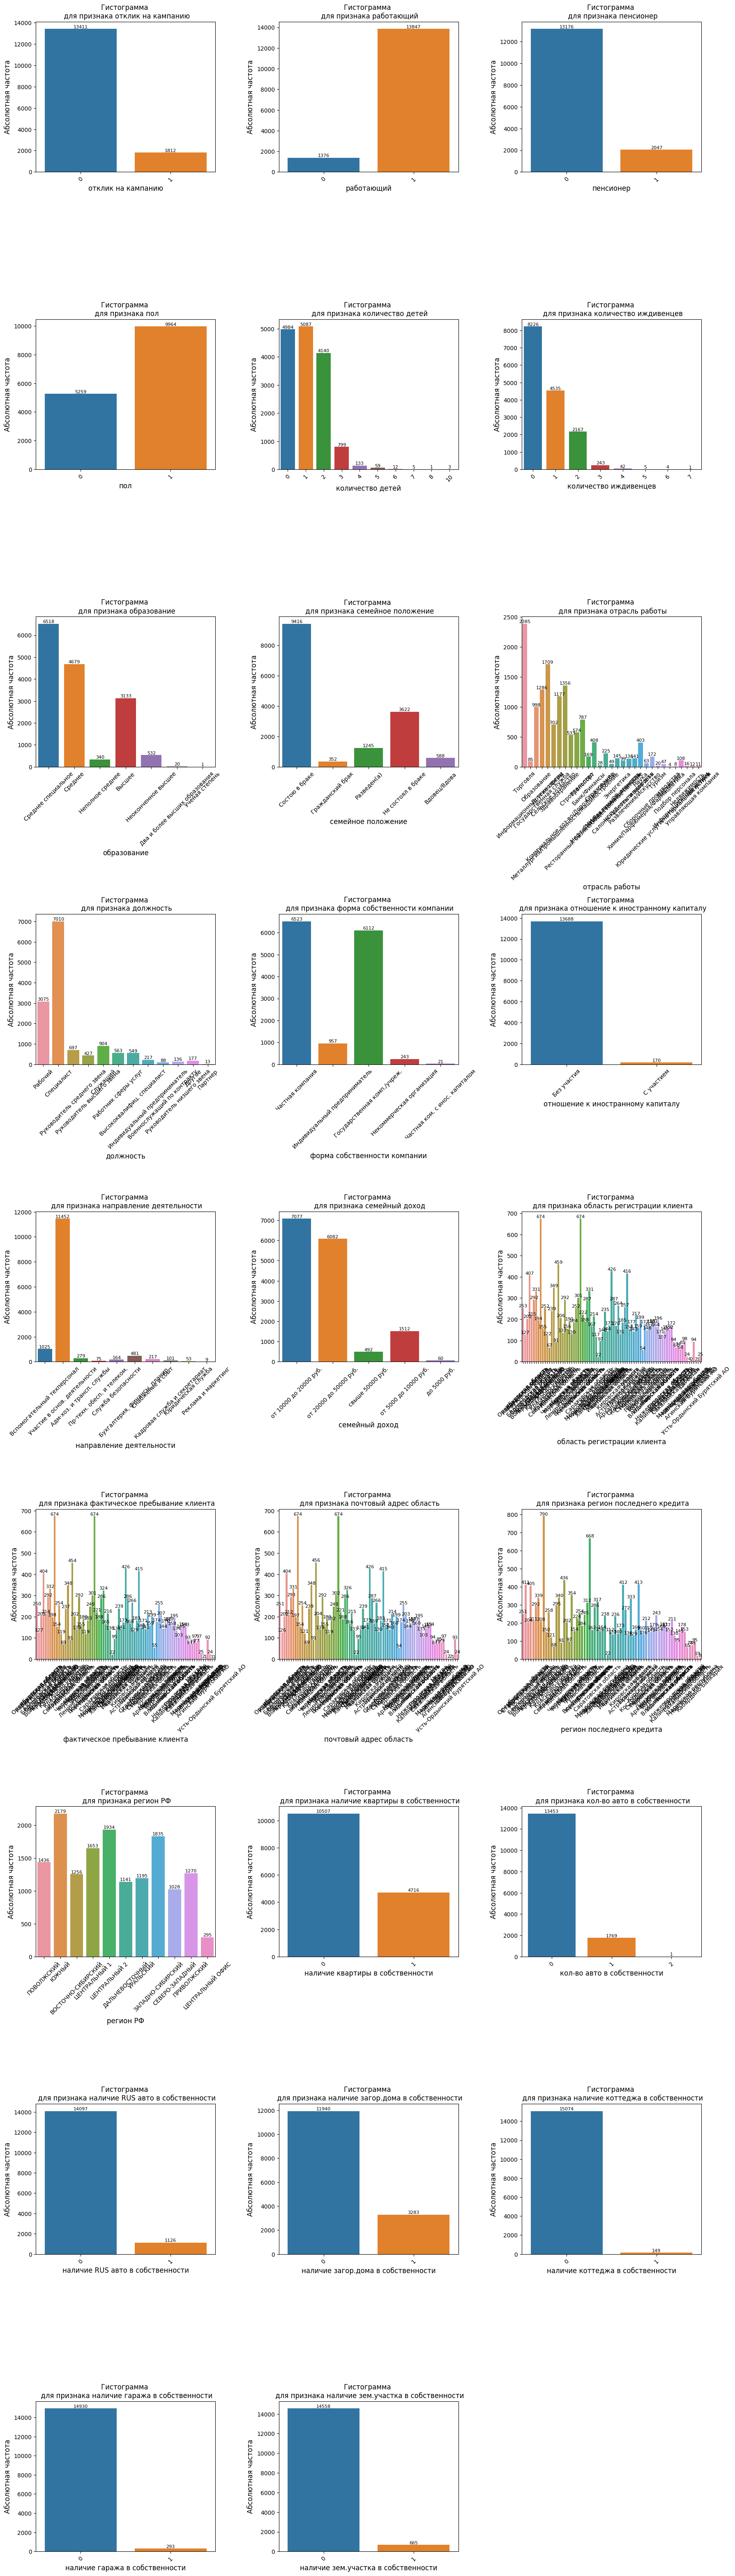

In [ ]:
fig, axes = plt.subplots(3, sharey=True, figsize=(18,84))
i=0
for i, col in enumerate(cat_vars):
    plt.subplot(12,3,i+1)
    ax = sns.countplot(x=col, data=df)
    plt.title("Гистограмма \n для признака {}".format(dict_to_rus_cat[col]))
    plt.xlabel(dict_to_rus_cat[col], fontsize = 12)
    plt.ylabel('Абсолютная частота', fontsize = 12)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}'.format(p.get_height()),
        (x.mean(), y),ha='center', va='bottom', fontsize = 8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.tight_layout(h_pad=1);

Некоторые графики в таком виде получились не очень приглядные, построю их отдельно.

*   Отрасль работы
*   направление деятельности
*   область регистрации клиента
*   фактическое пребывание клиента
*   почтовый адрес
*   регион последнего кредита

In [ ]:
horiz_vars = ['gen_industry', 'job_dir', 'reg_address_province', 'fact_address_province', 'postal_address_province', 'tp_province']

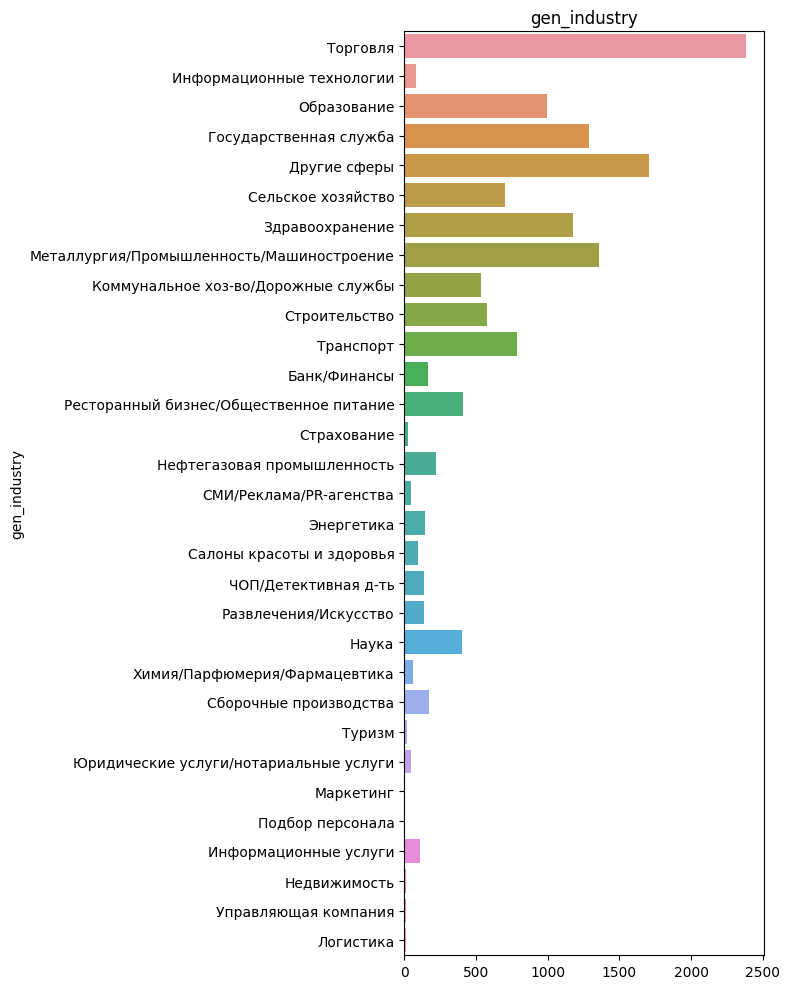

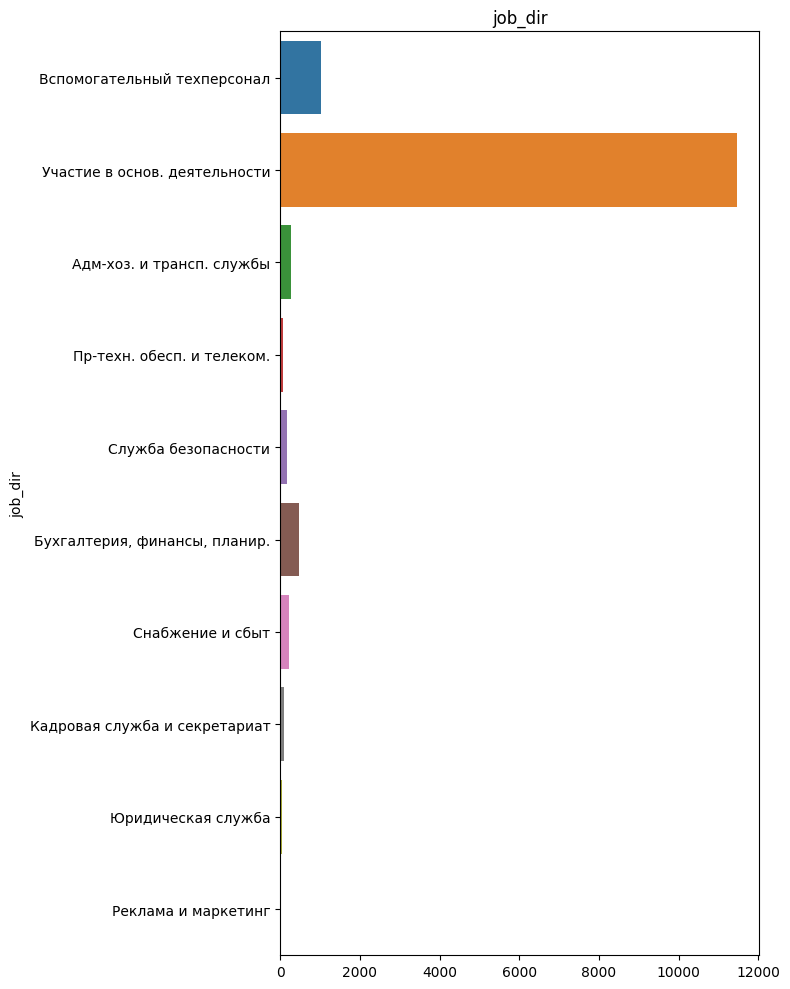

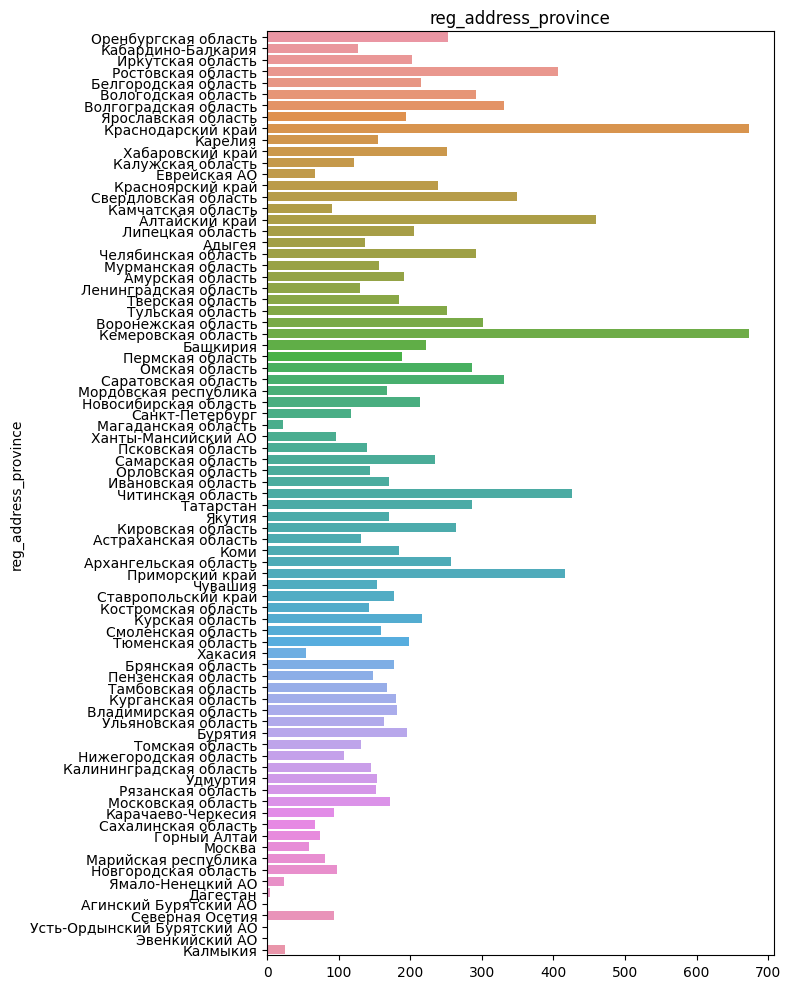

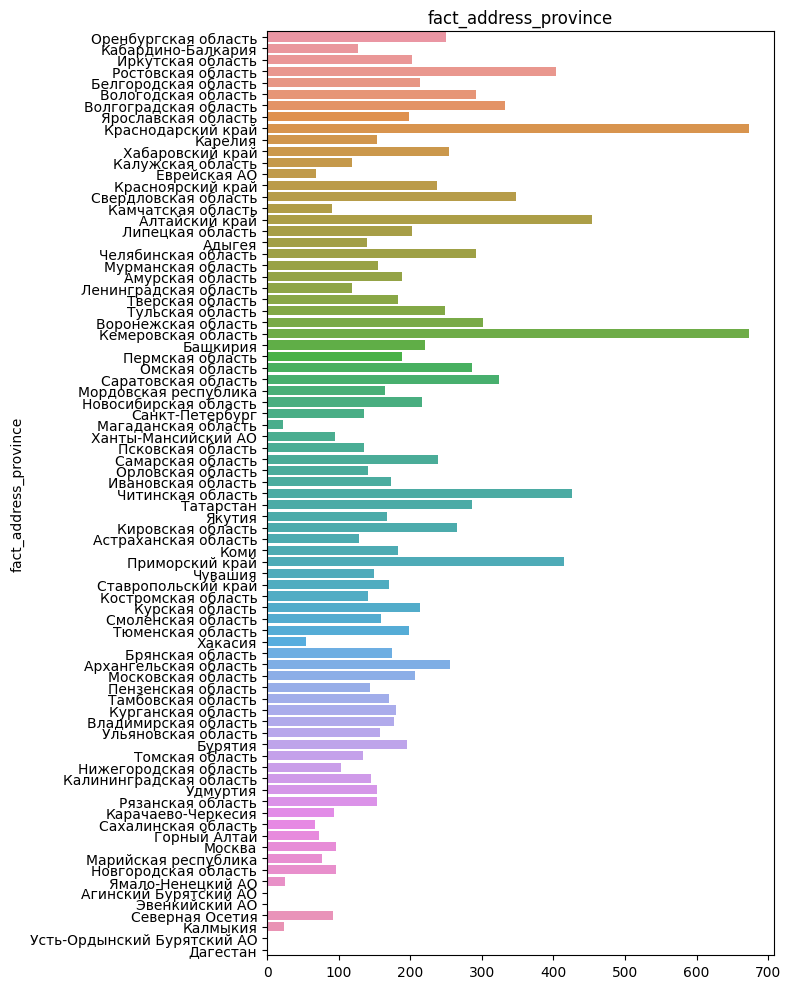

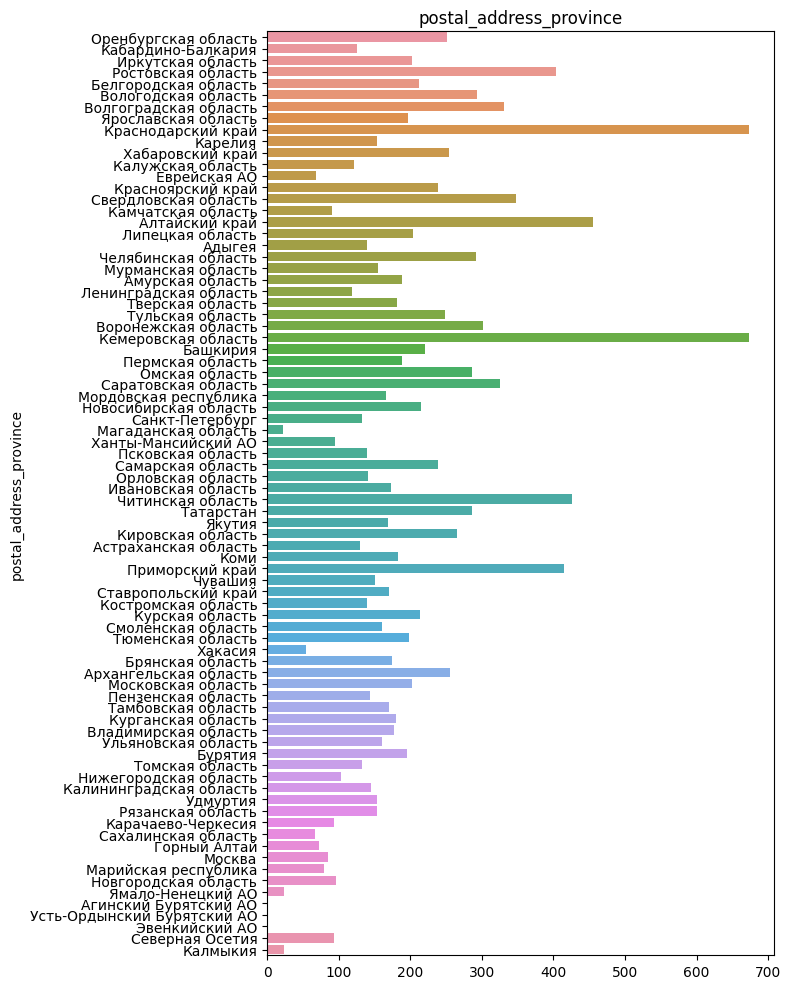

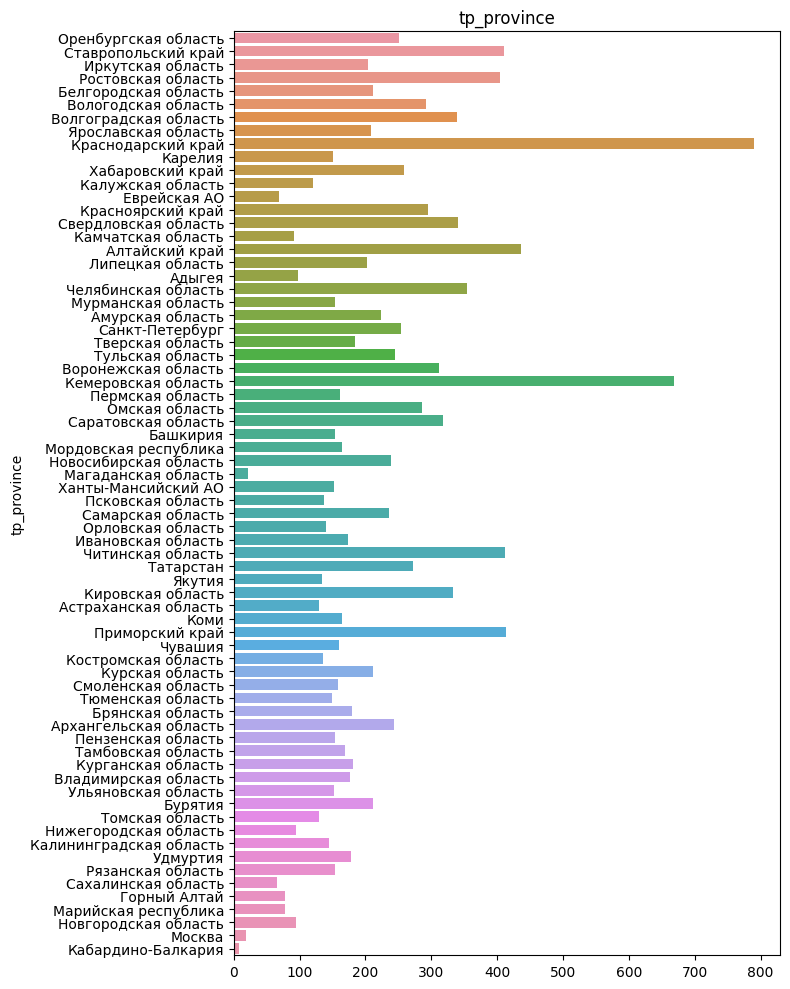

In [ ]:
for i, column in enumerate(horiz_vars):
  plt.figure(figsize=(8, 10))
  sns.countplot(y=column, data=df)
  plt.title(column)
  plt.xlabel('')
  plt.tight_layout()
  plt.show()

По графикам в категориальных признаках так же не вижу аномальных значений.

Посмотрю теперь интервальные признаки.

In [ ]:
int_vars = ['age','personal_income','credit','fact_living_term','work_time','loan_num_paym',\
            'loan_dlq_num','loan_max_dlq_amt','term']

In [ ]:
dict_to_rus_int = {'age': 'возраст',
               'personal_income': 'личный доход (руб.)',
               'credit': 'сумма последнего кредита (руб.)',
               'fact_living_term': 'проживает по адресу (мес.)',
               'work_time': 'время работы в компании (мес.)',
               'loan_num_paym': 'кол-во совершенных платежей',
               'loan_dlq_num': 'кол-во просрочек',
               'loan_max_dlq_amt': 'max сумма просрочки (руб.)',
               'term': 'срок кредита (мес.)'
               }

Ящики с усами и гистограммы для интервальных признаков

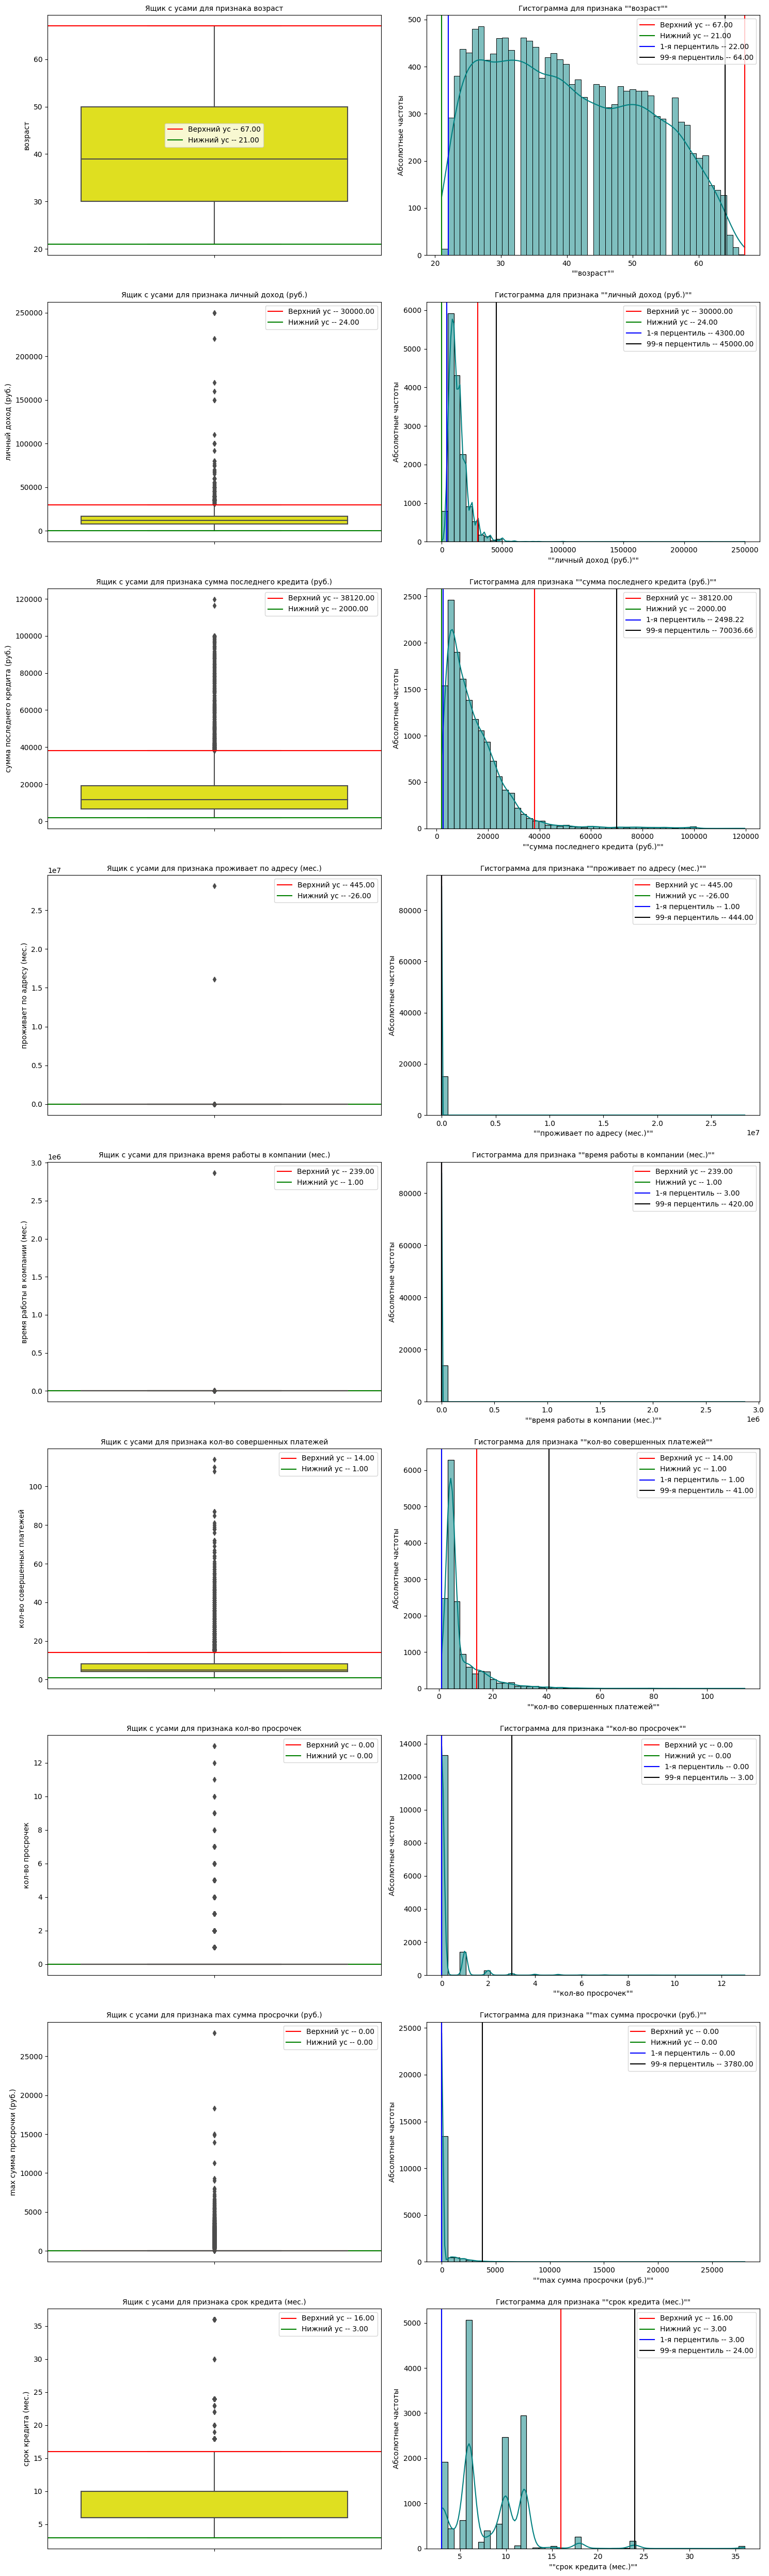

In [ ]:
plt.subplots(nrows=9,
             ncols=2,
             figsize=(15,50))
for index, col in enumerate(int_vars, start=0):
    plt.subplot(9,2,2*index+1)
    sns.boxplot(data=df,
            y=col,
            color='yellow')
    actual_loval, actual_hival = calc_boxplot(df[col])
    plt.axhline(actual_hival,
            color='red',
            label=f'Верхний ус -- {actual_hival:.2f}')
    plt.axhline(actual_loval,
            color='green',
            label=f'Нижний ус -- {actual_loval:.2f}')
    plt.title(f"Ящик с усами для признака {dict_to_rus_int.get(col)}", fontsize=10)
    plt.ylabel(f'{dict_to_rus_int.get(col)}', fontsize=10)
    plt.legend()
    plt.subplot(9,2,2*index+2)
    sns.histplot(data=df,
             x=col,
             color='teal',
             bins=50,
             kde=True)
    plt.title(f'Гистограмма для признака ""{dict_to_rus_int.get(col)}""', fontsize=10)
    plt.xlabel(f'""{dict_to_rus_int.get(col)}""', fontsize=10)
    plt.ylabel('Абсолютные частоты', fontsize=10)
    plt.axvline(actual_hival,
                color='red',
                label=f'Верхний ус -- {actual_hival:.2f}')
    plt.axvline(actual_loval,
                color='green',
                label=f'Нижний ус -- {actual_loval:.2f}')
    per_1 = np.nanpercentile(df[col], 1)
    per_99 = np.nanpercentile(df[col], 99)
    plt.axvline(per_1,
                color='blue',
                label=f'1-я перцентиль -- {per_1:.2f}')
    plt.axvline(per_99,
                color='black',
                label=f'99-я перцентиль -- {per_99:.2f}')
    plt.legend(loc='upper right')
    plt.tight_layout(h_pad=2)

По графикам делаю вывод, что некоторые признаки можно отнести к категориальным -
- проживает по адресу
- время работы в компании
- кол-во просрочек
- срок кредита

Перенесу их в категориальные ниже в работе.

Посмотрю описательную статистику.

In [ ]:
per = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
df[int_vars].describe(percentiles=per)

age  personal_income         credit  fact_living_term  \
count  15223.000000     15223.000000   15223.000000      1.522300e+04   
mean      40.406096     13853.836323   14667.959345      3.039340e+03   
std       11.601068      9015.467617   12147.873496      2.624554e+05   
min       21.000000        24.000000    2000.000000     -2.600000e+01   
1%        22.000000      4300.000000    2498.220000      1.000000e+00   
5%        24.000000      5000.000000    3500.000000      7.000000e+00   
25%       30.000000      8000.000000    6500.000000      4.100000e+01   
50%       39.000000     12000.000000   11550.000000      1.080000e+02   
75%       50.000000     17000.000000   19170.000000      2.040000e+02   
95%       60.000000     30000.000000   33800.000000      3.410000e+02   
99%       64.000000     45000.000000   70036.660000      4.440000e+02   
max       67.000000    250000.000000  119700.000000      2.810200e+07   

          work_time  loan_num_paym  loan_dlq_num  loan_max_dlq_amt  \
count  1.385500e+04   15223.000000  15223.000000      15223.000000   
mean   2.922120e+02       7.875977      0.195362        243.021626   
std    2.436483e+04       7.955747      0.685022        836.100116   
min    1.000000e+00       1.000000      0.000000          0.000000   
1%     3.000000e+00       1.000000      0.000000          0.000000   
5%     6.000000e+00       2.000000      0.000000          0.000000   
25%    2.400000e+01       4.000000      0.000000          0.000000   
50%    4.800000e+01       5.000000      0.000000          0.000000   
75%    1.100000e+02       8.000000      0.000000          0.000000   
95%    2.880000e+02      24.000000      1.000000       1900.000000   
99%    4.200000e+02      41.000000      3.000000       3780.000000   
max    2.867959e+06     114.000000     13.000000      28012.200000   

               term  
count  15223.000000  
mean       8.101031  
std        4.094090  
min        3.000000  
1%         3.000000  
5%         3.000000  
25%        6.000000  
50%        6.000000  
75%       10.000000  
95%       12.000000  
99%       24.000000  
max       36.000000

In [ ]:
int_vars = ['age','personal_income','credit','fact_living_term','work_time','loan_num_paym',\
            'loan_dlq_num','loan_max_dlq_amt','term']

Напишу фильтры на числовые признаки для очистки от аномалий.
Чистку буду делать очень аккуратно, большинство сделаю по 1 и 99 перцентелям

In [ ]:
filtered_personal_income = df.personal_income.between(np.nanpercentile(df['personal_income'], 1),\
                                                                  np.nanpercentile(df['personal_income'],99))

filtered_credit = df.credit.between(calc_boxplot(df.credit)[0], np.nanpercentile(df['credit'],99))

filtered_fact_living_term = df.fact_living_term.between(np.nanpercentile(df['fact_living_term'], 1),
                                                                    calc_boxplot(df.fact_living_term)[1])

filtered_work_time = df.work_time.between(np.nanpercentile(df['work_time'], 1),\
                                                      np.nanpercentile(df['work_time'],99))

filtered_loan_num_paym = df.loan_num_paym.between(np.nanpercentile(df['loan_num_paym'], 1),\
                                                      np.nanpercentile(df['loan_num_paym'],99))

filtered_loan_dlq_num = df.loan_dlq_num.between(np.nanpercentile(df['loan_dlq_num'], 1),\
                                                      np.nanpercentile(df['loan_dlq_num'],99))

Посчитаю процент потерь - 14.47

In [ ]:
(1 - df.loc[filtered_personal_income #1.73%
            & filtered_credit #1.005%
            & filtered_fact_living_term #1.018%
            & filtered_work_time #10.11%
            & filtered_loan_num_paym #0.90%
            & filtered_loan_dlq_num #0.85%
            ].shape[0] / df.shape[0])*100

14.471523352821391

Создаю новый df для отфильтрованных данных, чтобы не перезаписывать данные в основном df.

In [ ]:
df_filtered = pd.DataFrame()

df_filtered = df_filtered.append([df.loc[filtered_personal_income & filtered_credit & filtered_fact_living_term &\
                     filtered_work_time & filtered_loan_num_paym & filtered_loan_dlq_num]]);

<ipython-input-74-b7923c911a9a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append([df.loc[filtered_personal_income & filtered_credit & filtered_fact_living_term &\


Смотрю какая размерность получилась после фильтра.

In [ ]:
df_filtered.shape

(13020, 37)

Смотрю какая размерность была до аномалий.

In [ ]:
df.shape

(15223, 37)

***Восстановить пропущенные значения***

In [ ]:
df_filtered[cat_vars].isna().sum()

target                       0
socstatus_work_fl            0
socstatus_pens_fl            0
gender                       0
child_total                  0
dependants                   0
education                    0
marital_status               0
gen_industry                 0
gen_title                    0
org_tp_state                 0
org_tp_fcapital              0
job_dir                      0
family_income                0
reg_address_province         0
fact_address_province        0
postal_address_province      0
tp_province                258
region_nm                    1
fl_presence_fl               0
own_auto                     0
auto_rus_fl                  0
hs_presence_fl               0
cot_presence_fl              0
gar_presence_fl              0
land_presence_fl             0
dtype: int64

In [ ]:
df_filtered[int_vars].isna().sum()

age                 0
personal_income     0
credit              0
fact_living_term    0
work_time           0
loan_num_paym       0
loan_dlq_num        0
loan_max_dlq_amt    0
term                0
dtype: int64

т.к. пропусков после фильтрации осталось совсем мало, я их удалю.

In [ ]:
df_filtered = df_filtered.dropna()

In [ ]:
df_filtered.isna().sum()

id                         0
target                     0
age                        0
socstatus_work_fl          0
socstatus_pens_fl          0
gender                     0
child_total                0
dependants                 0
education                  0
marital_status             0
gen_industry               0
gen_title                  0
org_tp_state               0
org_tp_fcapital            0
job_dir                    0
family_income              0
personal_income            0
reg_address_province       0
fact_address_province      0
postal_address_province    0
tp_province                0
region_nm                  0
fl_presence_fl             0
own_auto                   0
auto_rus_fl                0
hs_presence_fl             0
cot_presence_fl            0
gar_presence_fl            0
land_presence_fl           0
credit                     0
term                       0
fact_living_term           0
work_time                  0
loan_num_paym              0
loan_dlq_num  

***Шаг 3. Добавьте в таблицу следующие признаки:***

- день недели, месяц и год взятия кредита;
- адрес регистрации и адрес фактического пребывания клиента совпадают (1 -- совпадает, 0 -- не совпадает);
- адрес фактического пребывания клиента и его почтовый адрес совпадают(1 -- совпадает, 0 -- не совпадает);
- адрес регистрации клиента и его почтовый адрес совпадают(1 -- совпадает, 0 -- не совпадает);
- почтовый, фактический и адрес регистрации совпадают (1 -- совпадают, 0 -- не совпадают);
- область регистрации, фактического пребывания, почтового адреса и область расположения торговой точки, где клиент брал кредит совпадают (1 -- совпадают, 0 -- не совпадают);

In [ ]:
df_filtered.columns

Index(['id', 'target', 'age', 'socstatus_work_fl', 'socstatus_pens_fl',
       'gender', 'child_total', 'dependants', 'education', 'marital_status',
       'gen_industry', 'gen_title', 'org_tp_state', 'org_tp_fcapital',
       'job_dir', 'family_income', 'personal_income', 'reg_address_province',
       'fact_address_province', 'postal_address_province', 'tp_province',
       'region_nm', 'fl_presence_fl', 'own_auto', 'auto_rus_fl',
       'hs_presence_fl', 'cot_presence_fl', 'gar_presence_fl',
       'land_presence_fl', 'credit', 'term', 'fact_living_term', 'work_time',
       'loan_num_paym', 'loan_dlq_num', 'loan_max_dlq_amt', 'date_credit'],
      dtype='object')

День недели, месяц и год взятия кредита;

In [ ]:
df_filtered['day_credit'] = df_filtered['date_credit'].dt.day_name()
df_filtered['month_credit'] = df_filtered['date_credit'].dt.month
df_filtered['year_credit'] = df_filtered['date_credit'].dt.year
df_filtered.head(2)

id  target  age  socstatus_work_fl  socstatus_pens_fl  gender  \
0  59910150       0   49                  1                  0       1   
1  59910230       0   32                  1                  0       1   

   child_total  dependants            education  marital_status  ... term  \
0            2           1  Среднее специальное  Состою в браке  ...    6   
1            3           3              Среднее  Состою в браке  ...    6   

  fact_living_term work_time loan_num_paym loan_dlq_num loan_max_dlq_amt  \
0              220      18.0             6            2           1580.0   
1              137      97.0             6            1           4020.0   

          date_credit day_credit month_credit year_credit  
0 2017-10-01 15:09:09     Sunday           10        2017  
1 2020-10-09 18:58:35     Friday           10        2020  

[2 rows x 40 columns]

адрес регистрации и адрес фактического пребывания клиента совпадают (1 -- совпадает, 0 -- не совпадает)

In [ ]:
df_filtered['address_reg_fakt'] = np.where(df_filtered.reg_address_province == df_filtered.fact_address_province, 1, 0)

адрес фактического пребывания клиента и его почтовый адрес совпадают(1 -- совпадает, 0 -- не совпадает)

In [ ]:
df_filtered['address_fakt_post'] = np.where(df_filtered.postal_address_province == df_filtered.fact_address_province, 1, 0)
df_filtered.head(2)

id  target  age  socstatus_work_fl  socstatus_pens_fl  gender  \
0  59910150       0   49                  1                  0       1   
1  59910230       0   32                  1                  0       1   

   child_total  dependants            education  marital_status  ...  \
0            2           1  Среднее специальное  Состою в браке  ...   
1            3           3              Среднее  Состою в браке  ...   

  work_time loan_num_paym loan_dlq_num loan_max_dlq_amt         date_credit  \
0      18.0             6            2           1580.0 2017-10-01 15:09:09   
1      97.0             6            1           4020.0 2020-10-09 18:58:35   

  day_credit  month_credit year_credit address_reg_fakt address_fakt_post  
0     Sunday            10        2017                1                 1  
1     Friday            10        2020                1                 1  

[2 rows x 42 columns]

адрес регистрации клиента и его почтовый адрес совпадают(1 -- совпадает, 0 -- не совпадает)

In [ ]:
df_filtered['address_reg_post'] = np.where(df_filtered.reg_address_province == df_filtered.postal_address_province, 1, 0)
df_filtered.head(2)

id  target  age  socstatus_work_fl  socstatus_pens_fl  gender  \
0  59910150       0   49                  1                  0       1   
1  59910230       0   32                  1                  0       1   

   child_total  dependants            education  marital_status  ...  \
0            2           1  Среднее специальное  Состою в браке  ...   
1            3           3              Среднее  Состою в браке  ...   

  loan_num_paym loan_dlq_num loan_max_dlq_amt         date_credit day_credit  \
0             6            2           1580.0 2017-10-01 15:09:09     Sunday   
1             6            1           4020.0 2020-10-09 18:58:35     Friday   

  month_credit  year_credit address_reg_fakt address_fakt_post  \
0           10         2017                1                 1   
1           10         2020                1                 1   

  address_reg_post  
0                1  
1                1  

[2 rows x 43 columns]

Проверю, правильно ли сработали условия

In [ ]:
df_filtered[['reg_address_province','fact_address_province','address_reg_fakt']]
df_filtered.address_reg_fakt.value_counts()
df_filtered.loc[df_filtered['address_reg_fakt']==0][['reg_address_province','fact_address_province','address_reg_fakt']]

reg_address_province fact_address_province  address_reg_fakt
80     Архангельская область       Санкт-Петербург                 0
504      Ханты-Мансийский АО     Тюменская область                 0
818    Ленинградская область       Санкт-Петербург                 0
922         Амурская область      Хабаровский край                 0
973    Ленинградская область       Санкт-Петербург                 0
...                      ...                   ...               ...
14699  Ленинградская область       Санкт-Петербург                 0
14919   Марийская республика     Ямало-Ненецкий АО                 0
15012  Ленинградская область       Санкт-Петербург                 0
15021      Красноярский край               Хакасия                 0
15215    Ульяновская область     Рязанская область                 0

[109 rows x 3 columns]

почтовый, фактический и адрес регистрации совпадают (1 -- совпадают, 0 -- не совпадают)

In [ ]:
df_filtered['address_reg_fakt_post'] = np.where((df_filtered['postal_address_province'] == df_filtered['fact_address_province']) \
                                                & (df_filtered['postal_address_province'] == df_filtered['reg_address_province'])\
                                                & (df_filtered['fact_address_province'] == df_filtered['reg_address_province']), 1, 0)

область регистрации, фактического пребывания, почтового адреса и область расположения торговой точки, где клиент брал кредит совпадают (1 -- совпадают, 0 -- не совпадают);

In [ ]:
df_filtered['address_all_true'] = np.where((df_filtered['postal_address_province'] == df_filtered['fact_address_province']) \
                                         & (df_filtered['postal_address_province'] == df_filtered['reg_address_province'])\
                                         & (df_filtered['fact_address_province'] == df_filtered['reg_address_province'])\
                                         & (df_filtered['postal_address_province'] == df_filtered['tp_province'])\
                                         & (df_filtered['fact_address_province'] == df_filtered['tp_province'])\
                                         & (df_filtered['reg_address_province'] == df_filtered['tp_province']), 1, 0)

df_filtered['address_all_true'].value_counts()

1    11773
0      988
Name: address_all_true, dtype: int64

***Шаг 4. Провести исследовательский анализ данных:***

- исследовать динамику количества кредитов по годам, месяцам;
- исследовать числовые и категориальные признаки в разрезе целевого признака;
- сделать выводы о влиянии признаков на целевой признак.

In [ ]:
df_filtered.columns

Index(['id', 'target', 'age', 'socstatus_work_fl', 'socstatus_pens_fl',
       'gender', 'child_total', 'dependants', 'education', 'marital_status',
       'gen_industry', 'gen_title', 'org_tp_state', 'org_tp_fcapital',
       'job_dir', 'family_income', 'personal_income', 'reg_address_province',
       'fact_address_province', 'postal_address_province', 'tp_province',
       'region_nm', 'fl_presence_fl', 'own_auto', 'auto_rus_fl',
       'hs_presence_fl', 'cot_presence_fl', 'gar_presence_fl',
       'land_presence_fl', 'credit', 'term', 'fact_living_term', 'work_time',
       'loan_num_paym', 'loan_dlq_num', 'loan_max_dlq_amt', 'date_credit',
       'day_credit', 'month_credit', 'year_credit', 'address_reg_fakt',
       'address_fakt_post', 'address_reg_post', 'address_reg_fakt_post',
       'address_all_true'],
      dtype='object')

исследовать динамику количества кредитов по годам, месяцам;

Смотрю, какую картинку видно из дф

In [ ]:
df_groupby_count_id = df_filtered.groupby(['year_credit','month_credit']).agg(count_credits = ('id','count')).reset_index()
df_groupby_count_id.head(12)

year_credit  month_credit  count_credits
0          2015             1            146
1          2015             2            144
2          2015             3            155
3          2015             4            145
4          2015             5            148
5          2015             6            142
6          2015             7            137
7          2015             8            139
8          2015             9            168
9          2015            10            137
10         2015            11            149
11         2015            12            138

Посмотрю средние значения по годам (mean) и серединные значения выборок (median)

In [ ]:
df_groupby_count_id.groupby('year_credit')['count_credits'].agg(['mean', 'median']).round(0).reset_index()

year_credit   mean  median
0         2015  146.0   144.0
1         2016  154.0   153.0
2         2017  158.0   159.0
3         2018  148.0   145.0
4         2019  148.0   148.0
5         2020  152.0   151.0
6         2021  157.0   156.0

Видно, что среднее и медиана по годам практически одинаковы, что Может говорить о нормальном распределении.

Посмотрю средние значения по годам и месяцам (mean) и серединные значения выборок (median)

In [ ]:
df_groupby_count_id.groupby(['year_credit','month_credit'])['count_credits']\
                            .agg(['mean', 'median']).round(0).reset_index().tail(30) #.head(54)

year_credit  month_credit   mean  median
54         2019             7  162.0   162.0
55         2019             8  142.0   142.0
56         2019             9  137.0   137.0
57         2019            10  123.0   123.0
58         2019            11  176.0   176.0
59         2019            12  153.0   153.0
60         2020             1  150.0   150.0
61         2020             2  147.0   147.0
62         2020             3  173.0   173.0
63         2020             4  186.0   186.0
64         2020             5  136.0   136.0
65         2020             6  152.0   152.0
66         2020             7  156.0   156.0
67         2020             8  153.0   153.0
68         2020             9  134.0   134.0
69         2020            10  133.0   133.0
70         2020            11  155.0   155.0
71         2020            12  150.0   150.0
72         2021             1  136.0   136.0
73         2021             2  167.0   167.0
74         2021             3  148.0   148.0
75         2021             4  147.0   147.0
76         2021             5  185.0   185.0
77         2021             6  156.0   156.0
78         2021             7  143.0   143.0
79         2021             8  145.0   145.0
80         2021             9  173.0   173.0
81         2021            10  157.0   157.0
82         2021            11  163.0   163.0
83         2021            12  162.0   162.0

Видно, что существенных различий по месяцам нет, в каждом году есть 1-2 месяца с
наибольшим количеством кредитов, в каждом году эти месяцы разные.

Смотрю данные по годам на графиках

In [ ]:
df_to_plot = df_filtered.groupby('year_credit').agg(count_credits = ('id','count'))\
            .reset_index().sort_values(by='count_credits', ascending=False).head(10)

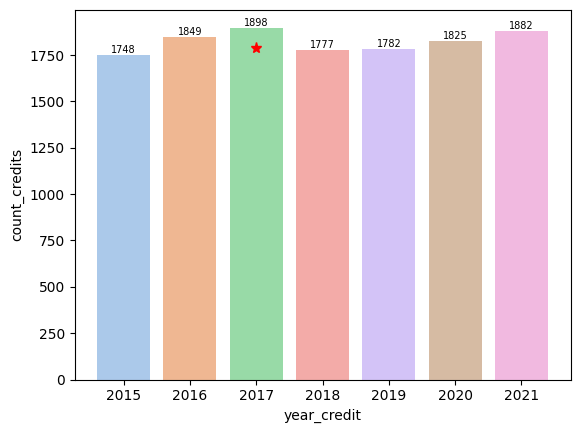

In [ ]:
ax = sns.barplot(data=df_to_plot,
                 x='year_credit',
                 y='count_credits',
                 palette='pastel')
ax.bar_label(ax.containers[0], fontsize=7)
ax.plot(2, 1790, "*", markersize=8, color="r")
plt.show();

По графику видно, что наиболее кредитный год был 2017

Теперь посмотрим данные в разрезе по месяцам

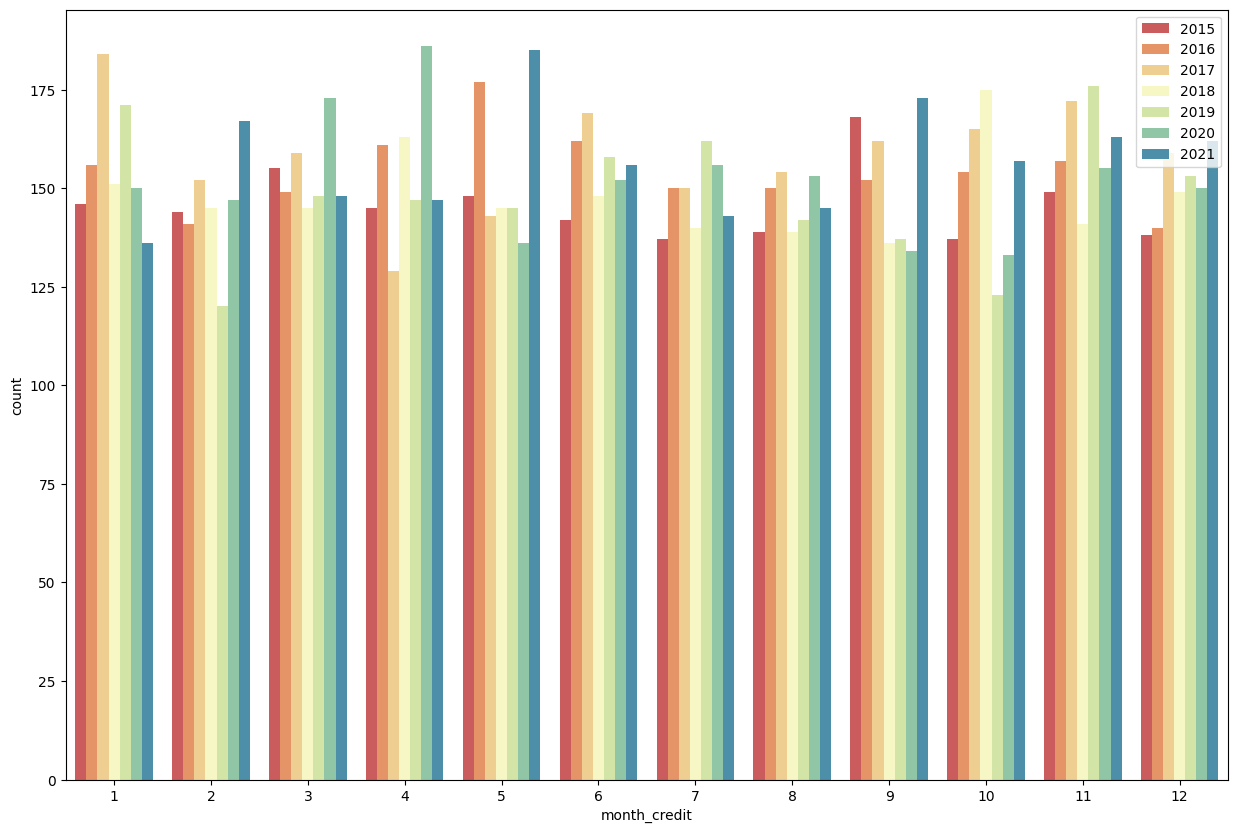

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data = df_filtered,
              x = 'month_credit',
              hue = 'year_credit',
              palette='Spectral'
              )
plt.legend(loc='upper right');

График подтверждает, что существенных различий по месяцам нет, в каждом году есть 1-2 месяца с наибольшим количеством кредитов, в каждом году эти месяцы разные.

***Исследовать числовые и категориальные признаки в разрезе целевого признака;***




In [ ]:
df_filtered.columns

Index(['id', 'target', 'age', 'socstatus_work_fl', 'socstatus_pens_fl',
       'gender', 'child_total', 'dependants', 'education', 'marital_status',
       'gen_industry', 'gen_title', 'org_tp_state', 'org_tp_fcapital',
       'job_dir', 'family_income', 'personal_income', 'reg_address_province',
       'fact_address_province', 'postal_address_province', 'tp_province',
       'region_nm', 'fl_presence_fl', 'own_auto', 'auto_rus_fl',
       'hs_presence_fl', 'cot_presence_fl', 'gar_presence_fl',
       'land_presence_fl', 'credit', 'term', 'fact_living_term', 'work_time',
       'loan_num_paym', 'loan_dlq_num', 'loan_max_dlq_amt', 'date_credit',
       'day_credit', 'month_credit', 'year_credit', 'address_reg_fakt',
       'address_fakt_post', 'address_reg_post', 'address_reg_fakt_post',
       'address_all_true'],
      dtype='object')

Убираю следующие признаки из интервальных -
 - проживает по адресу fact_living_term
 - кол-во просрочек loan_dlq_num
 - срок кредита term
 - максимальная сумма просрочки loan_max_dlq_amt

In [ ]:
int_vars_new = ['age','personal_income','credit','work_time','loan_num_paym']

In [ ]:
dict_int_new = {'age':'Возраст',
                'personal_income':'Личный доход',
                'credit':'Сумма последнего кредита',
                'work_time':'Время работы в компании (мес)',
                'loan_num_paym':'Количество платежей'}

Считаю выборочные статистики для числовых признаков

In [ ]:
df.groupby('target')[int_vars_new].agg(['mean', 'median']).round(0)

age        personal_income            credit          work_time  \
        mean median            mean   median     mean   median      mean   
target                                                                     
0       41.0   40.0         13540.0  12000.0  14498.0  11496.0     325.0   
1       37.0   36.0         16173.0  15000.0  15926.0  12175.0      64.0   

              loan_num_paym         
       median          mean median  
target                              
0        48.0           8.0    5.0  
1        36.0           7.0    5.0

Можно предположить, что отклик на рекламу есть у человека в среднем 37 лет, со средним личным доходом 16 тыс.руб.

Построю графики для числовых признаков в разрезе таргета.

<ipython-input-92-88a73b9382dc>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)
<ipython-input-92-88a73b9382dc>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)
<ipython-input-92-88a73b9382dc>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


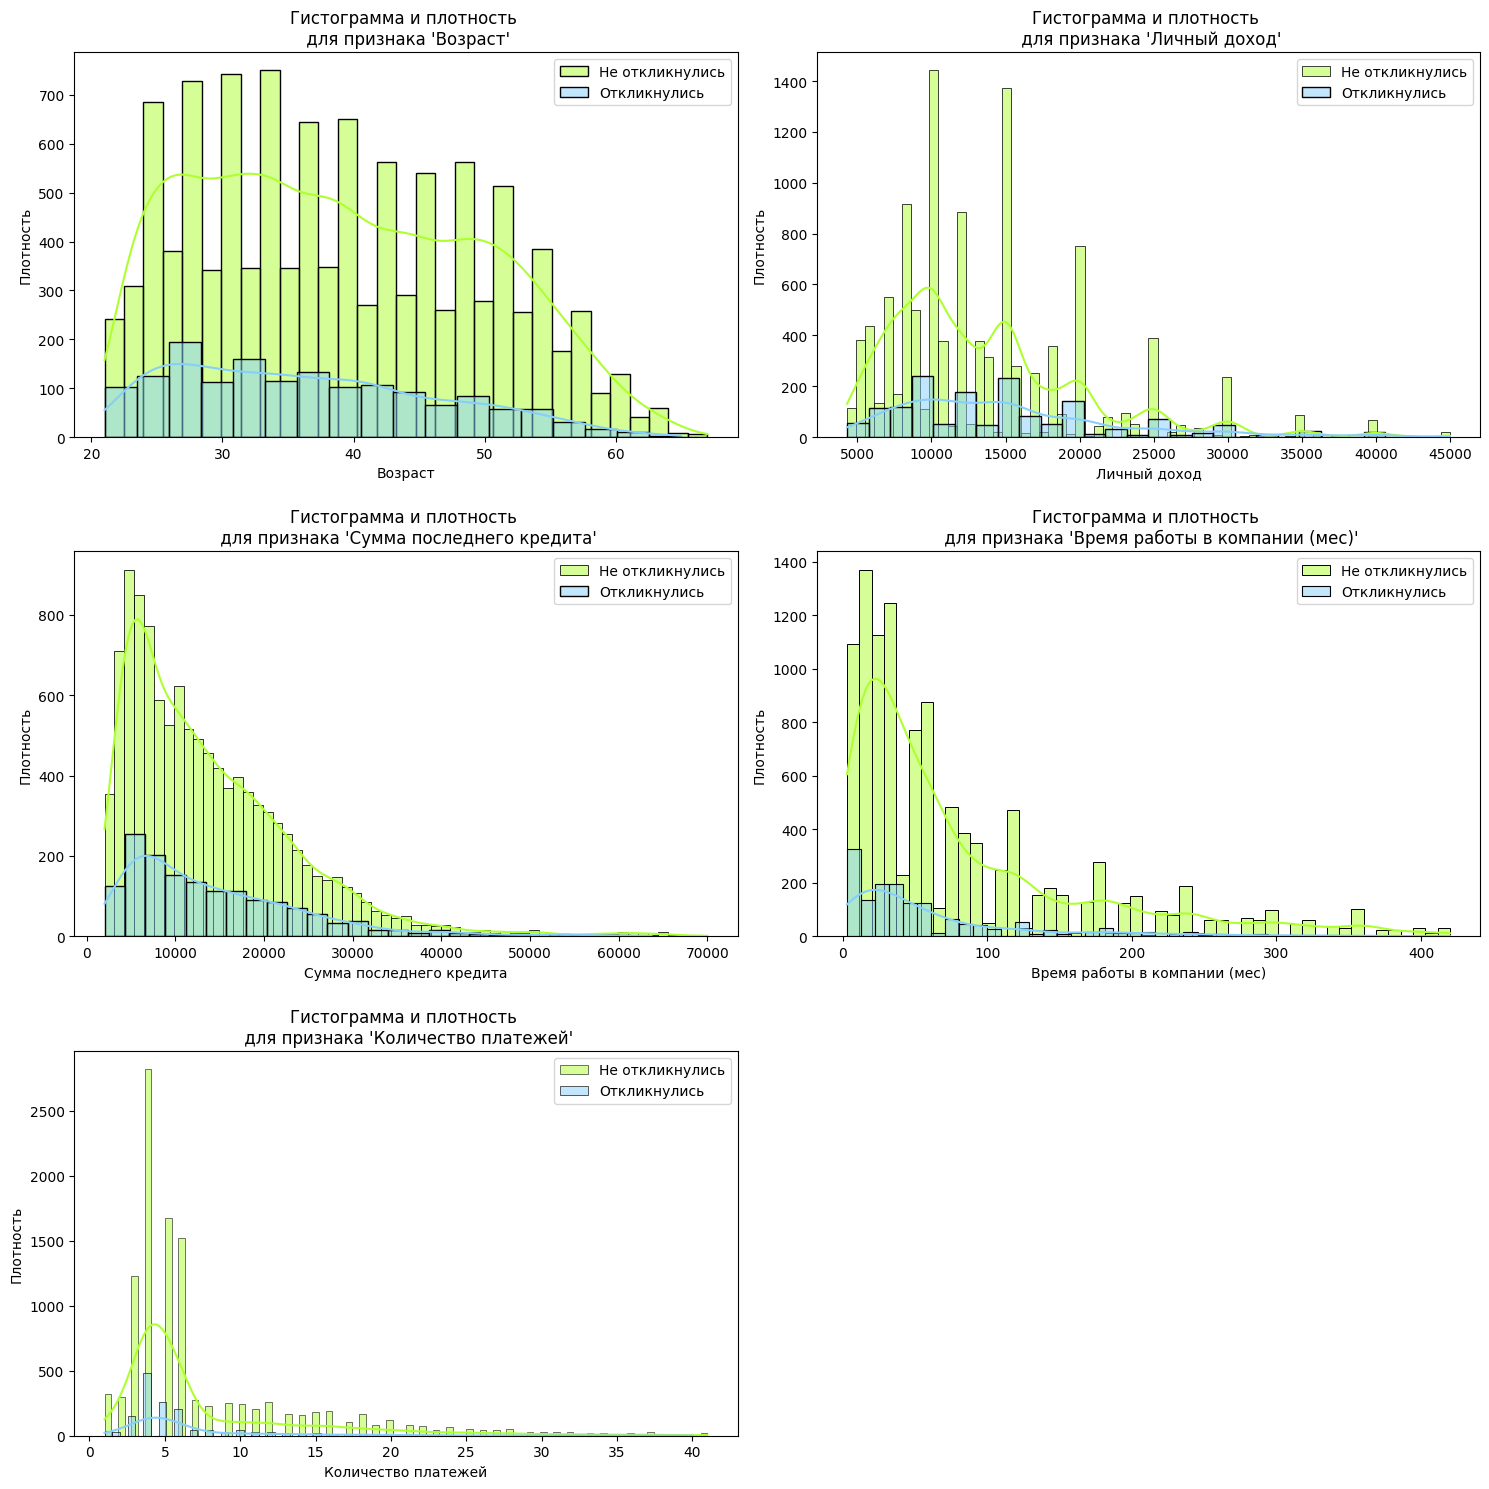

In [ ]:
fig, axes = plt.subplots(3, figsize=(15,15))
i=0
for i, col in enumerate(int_vars_new):
    plt.subplot(3,2,i+1)
    ax = sns.histplot(df_filtered[df_filtered.target == 0][col], label = 'Не откликнулись', kde=True, color='greenyellow')
    ax = sns.histplot(df_filtered[df_filtered.target == 1][col], label = 'Откликнулись', kde=True, color='lightskyblue')
    plt.title(f"Гистограмма и плотность \n для признака '{dict_int_new[col]}'")
    plt.xlabel(dict_int_new[col])
    plt.ylabel('Плотность')
    plt.legend()
plt.tight_layout(h_pad=2);

По графику можно предположить, что основной возраст откликнувшихся 25-45 лет,

с личным доходом от 6 до 20 тыс,

чем меньше сумма последнего кредита, тем больше отклик,

чем меньше время работы в компании, тем больше отклик.

В категории добавляю созданные признаки 'месяц взятия кредита' и 'год'.

In [ ]:
cat_vars_new = ['socstatus_work_fl','socstatus_pens_fl','gender',\
            'child_total','dependants','education','marital_status',\
            'gen_title','org_tp_state','org_tp_fcapital','job_dir',\
            'family_income',\
            'fl_presence_fl', 'own_auto','auto_rus_fl','hs_presence_fl',\
            'cot_presence_fl','gar_presence_fl','land_presence_fl','loan_dlq_num',\
            'term','month_credit','year_credit']

In [ ]:
dict_cat_new = {'socstatus_work_fl':'работающий',
                'socstatus_pens_fl':'пенсионер',
                'gender':'пол',
                'child_total':'количество детей',
                'dependants':'количество иждивенцев',
                'education':'образование',
                'marital_status':'семейное положение',
                'gen_industry':'отрасль работы',
                'gen_title':'должность',
                'org_tp_state':'форма собственности компании',
                'org_tp_fcapital':'отношение к иностранному капиталу',
                'job_dir':'направление деятельности',
                'family_income':'семейный доход',
                'reg_address_province':'область регистрации клиента',
                'fact_address_province':'фактическое пребывание клиента',
                'postal_address_province':'почтовый адрес область',
                'tp_province':'регион последнего кредита',
                'region_nm':'регион РФ',
                'fl_presence_fl':'наличие квартиры в собственности',
                'own_auto':'кол-во авто в собственности',
                'auto_rus_fl':'наличие RUS авто в собственности',
                'hs_presence_fl':'наличие загор.дома в собственности',
                'cot_presence_fl':'наличие коттеджа в собственности',
                'gar_presence_fl':'наличие гаража в собственности',
                'land_presence_fl':'наличие зем.участка в собственности',
                'fact_living_term':'проживает по адресу (мес)',
                'term':'срок кредита',
                'loan_max_dlq_amt':'максимальная сумма просрочки',
                'loan_dlq_num':'количество просрочек',
                'month_credit':'месяц взятия кредита',
                'year_credit':'год взятия кредита'}

Построю диаграммы по категориальным признакам в разрезе таргета.

<ipython-input-95-55adec8ef259>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12,2,i+1)
<ipython-input-95-55adec8ef259>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12,2,i+1)
<ipython-input-95-55adec8ef259>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12,2,i+1)
<ipython-input-95-55adec8ef259>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12,2,i+1)
<ipython-input-95-55adec8ef259>:4: MatplotlibDeprecationWarning: Auto-remova

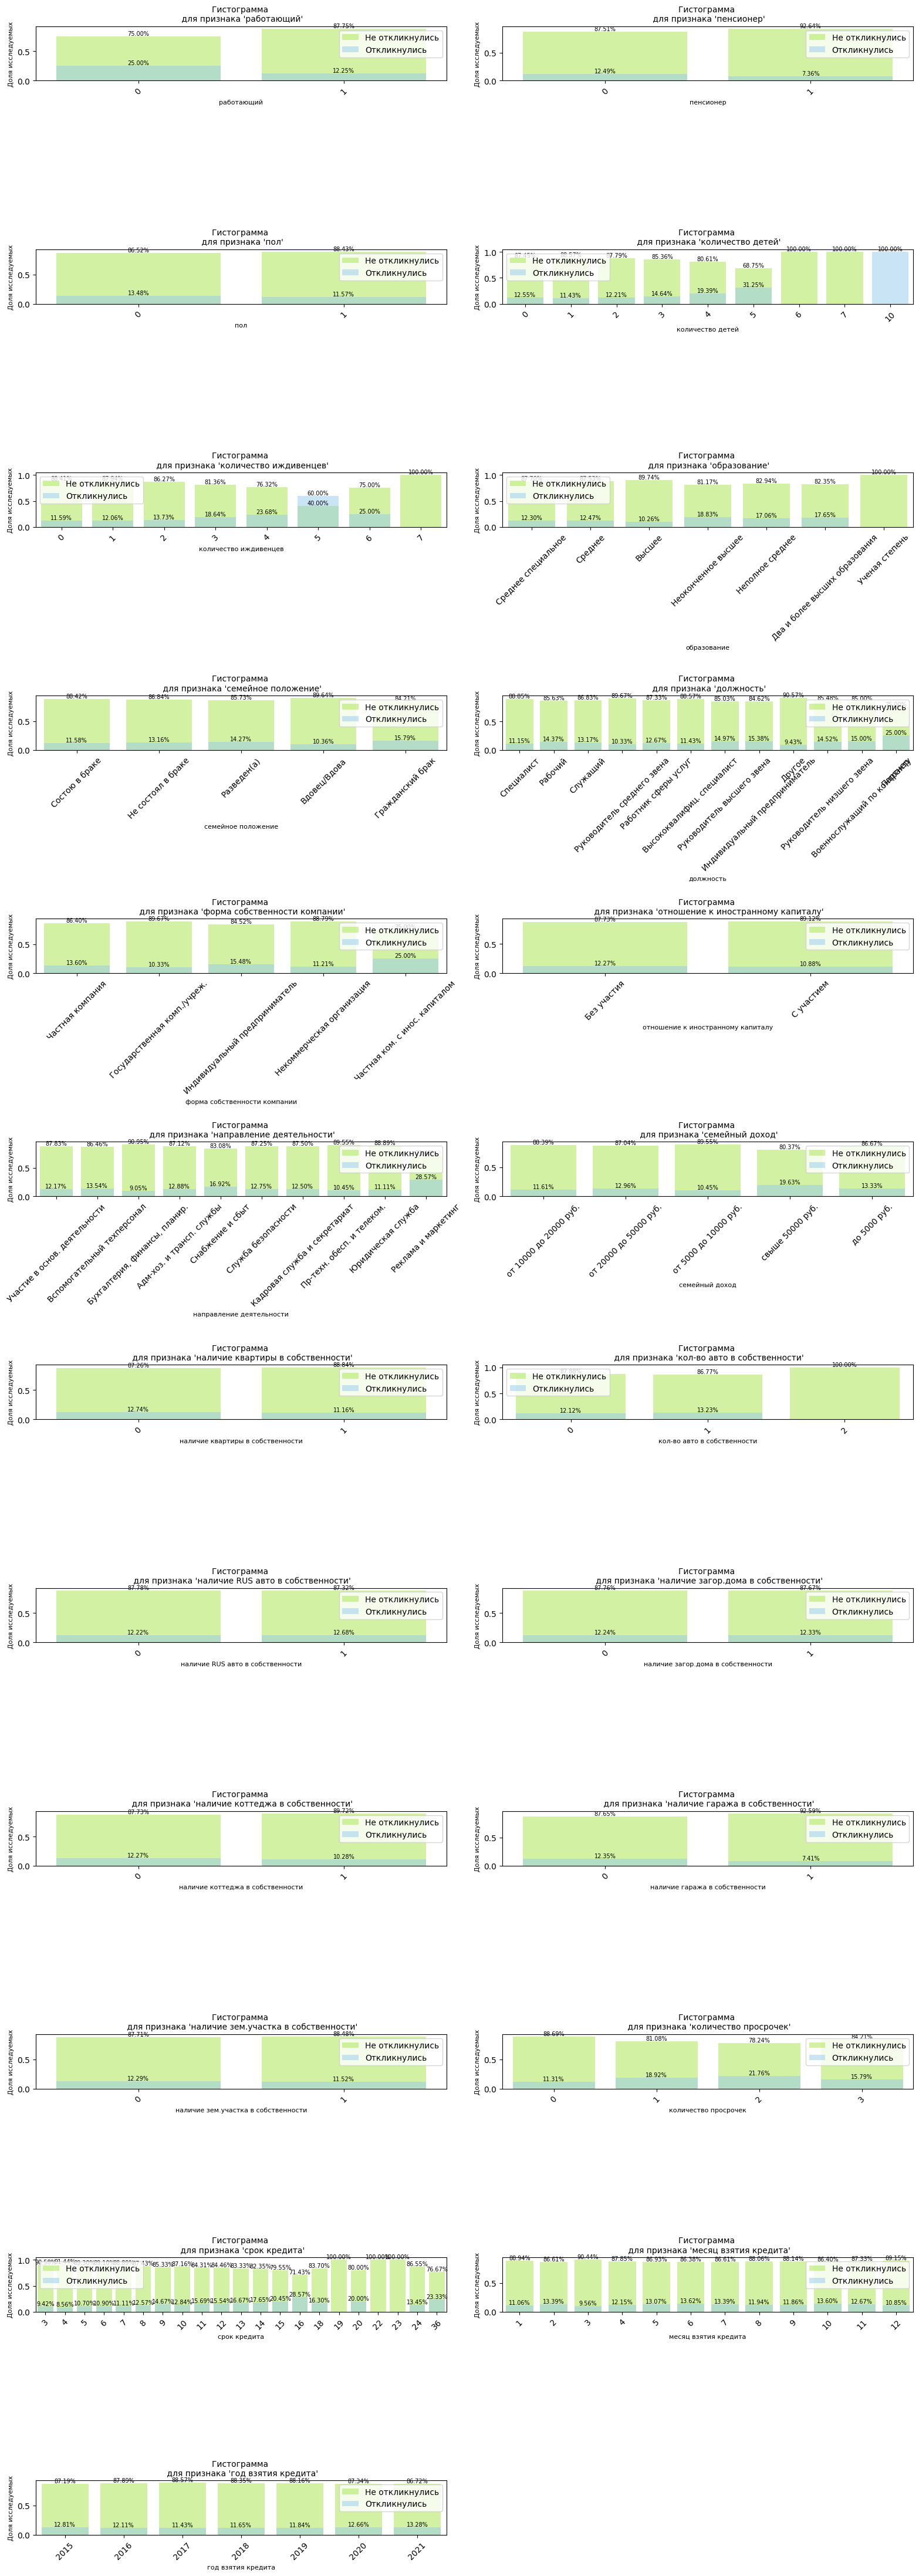

In [ ]:
fig, axes = plt.subplots(12, figsize=(16,44))
i=0
for i, col in enumerate(cat_vars_new):
    plt.subplot(12,2,i+1)
    data_all = df_filtered[col].value_counts()
    r = (pd.DataFrame([df_filtered[df_filtered.target == 0][col].value_counts()/data_all,
                       df_filtered[df_filtered.target == 1][col].value_counts()/data_all]).T)
    r.columns = ['0','1']
    ax1 = sns.barplot(x = r.index, y = r['0'], data = r, color='greenyellow',
                      alpha = 0.5, label = 'Не откликнулись')
    ax2 = sns.barplot(x = r.index, y = r['1'], data = r, color='lightskyblue',
                      alpha = 0.5, label = 'Откликнулись')
    plt.title("Гистограмма \n для признака '{}'".format(dict_cat_new[col]), fontsize = 10)
    plt.xlabel(dict_cat_new[col], fontsize = 8)
    plt.ylabel('Доля исследуемых', fontsize = 8)
    plt.legend()
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y),
            (x.mean(), y),ha='center', va='bottom', fontsize = 7)
    plt.xticks(rotation = 45)
plt.tight_layout(h_pad=2);

Выводы по гистограммам -

1.   работающие - у неработающих отклик на рекламу больше
2.   пенсионеры - у не пенсионеров отклик на рекламу больше
3.   образование - отклик немного больше у людей, начиная с неоконченного высшего образования и выше
4.   семейный доход выше 50.000 руб. отклик больше
5.   срок кредита-чем выше срок, тем больше отклик







Тут надо перекодировать некоторые признаки, чтобы увидеть корреляцию - сделаю ниже.

In [ ]:
df_filtered.corr()

<ipython-input-64-3b1745aa73cf>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filtered.corr()


id    target       age  socstatus_work_fl  \
id                     1.000000  0.014742 -0.031102          -0.002811   
target                 0.014742  1.000000 -0.071873          -0.009733   
age                   -0.031102 -0.071873  1.000000          -0.039585   
socstatus_work_fl     -0.002811 -0.009733 -0.039585           1.000000   
socstatus_pens_fl     -0.000356 -0.032343  0.367565          -0.115724   
gender                 0.051569 -0.027980  0.114021          -0.005793   
child_total            0.007776  0.015680  0.242213          -0.004417   
dependants             0.026015  0.036086 -0.207741           0.021403   
personal_income       -0.020343  0.071258 -0.013310           0.014152   
fl_presence_fl        -0.002621 -0.022097  0.144018          -0.003863   
own_auto               0.012986  0.010738 -0.026545          -0.010033   
auto_rus_fl            0.010495  0.003722 -0.020681          -0.016084   
hs_presence_fl         0.029909  0.001077  0.107566           0.005083   
cot_presence_fl       -0.011116 -0.005540  0.043898           0.002303   
gar_presence_fl        0.037217 -0.020600  0.049387          -0.019417   
land_presence_fl       0.034160 -0.004568  0.044212          -0.010833   
credit                 0.000976  0.020583  0.103280           0.003900   
term                   0.000813  0.063528  0.025827           0.012840   
fact_living_term       0.001819 -0.055423  0.396346          -0.022943   
work_time             -0.015459 -0.076783  0.432146          -0.022677   
loan_num_paym          0.299136 -0.040680  0.058028          -0.011160   
loan_dlq_num          -0.017933  0.071792 -0.032574           0.001451   
loan_max_dlq_amt      -0.035941  0.070188 -0.030202          -0.002110   
month_credit           0.017183  0.005737  0.005067          -0.006374   
year_credit           -0.000353  0.006790  0.006241          -0.007594   
address_reg_fakt      -0.011531 -0.017244  0.065549          -0.002325   
address_fakt_post     -0.015794 -0.002237  0.033870          -0.001195   
address_reg_post      -0.003916 -0.018756  0.055992          -0.001989   
address_reg_fakt_post -0.011531 -0.017244  0.065549          -0.002325   
address_all_true      -0.011055 -0.027637  0.003735           0.004459   

                       socstatus_pens_fl    gender  child_total  dependants  \
id                             -0.000356  0.051569     0.007776    0.026015   
target                         -0.032343 -0.027980     0.015680    0.036086   
age                             0.367565  0.114021     0.242213   -0.207741   
socstatus_work_fl              -0.115724 -0.005793    -0.004417    0.021403   
socstatus_pens_fl               1.000000  0.086164     0.038267   -0.149566   
gender                          0.086164  1.000000     0.054492   -0.060504   
child_total                     0.038267  0.054492     1.000000    0.579866   
dependants                     -0.149566 -0.060504     0.579866    1.000000   
personal_income                 0.025435 -0.280170    -0.057963   -0.002875   
fl_presence_fl                  0.065413  0.087982     0.005559   -0.054717   
own_auto                       -0.038973 -0.266508     0.014017    0.048302   
auto_rus_fl                    -0.034618 -0.211279     0.031434    0.052586   
hs_presence_fl                  0.021177  0.005277     0.127307    0.064589   
cot_presence_fl                 0.025823  0.017244     0.005604   -0.013984   
gar_presence_fl                 0.016991 -0.044469     0.030747    0.006057   
land_presence_fl                0.019489  0.012373     0.051163    0.024738   
credit                          0.083084  0.011557     0.024791   -0.034946   
term                            0.019141  0.016642     0.036552    0.005858   
fact_living_term                0.155770  0.080943     0.085943   -0.146173   
work_time                       0.117648  0.095389     0.150512   -0.061413   
loan_num_paym                   0.046970  0.034628     0.036849    0.037650

С таргетом наиболее коррелируют такие признаки, как -
- возраст (отрицательная корреляция) - чем старше возраст, тем отклик на рекламу меньше.
- личный доход - чем больше доход, тем больше отклик.
- срок кредита - чем больше срок кредита, тем больше отклик.
- срок проживания на последнем месте - чем меньше живет на последнем месте, тем больше отклик.
- срок работы на последнем месте - чем меньше работает на последнем месте, тем больше отклик.
- кол-во просрочек (loan_dlq_num) - чем больше просрочек, тем больше отклик
- max сумма просрочки (loan_max_dlq_amt) чем больше сумма просрочки, тем больше отклик

Попробую перекодировать признаки для оценки корреляции с ними

Возьму Образование, Семейный доход, Семейное положение

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_filtered.education)
df_filtered['education_tr'] = le.transform(df_filtered.education)
le.fit(df_filtered.family_income)
df_filtered['family_income_tr'] = le.transform(df_filtered.family_income)
le.fit(df_filtered.marital_status)
df_filtered['marital_status_tr'] = le.transform(df_filtered.marital_status)
df_filtered.head(2)


id  target  age  socstatus_work_fl  socstatus_pens_fl  gender  \
0  59910150       0   49                  1                  0       1   
1  59910230       0   32                  1                  0       1   

   child_total  dependants            education  marital_status  ...  \
0            2           1  Среднее специальное  Состою в браке  ...   
1            3           3              Среднее  Состою в браке  ...   

  day_credit month_credit year_credit address_reg_fakt address_fakt_post  \
0     Sunday           10        2017                1                 1   
1     Friday           10        2020                1                 1   

  address_reg_post  address_reg_fakt_post address_all_true education_tr  \
0                1                      1                1            5   
1                1                      1                0            4   

  family_income_tr  
0                1  
1                1  

[2 rows x 47 columns]

In [ ]:
print(df_filtered['target'].corr(df_filtered['education_tr']))
print(df_filtered['target'].corr(df_filtered['family_income_tr']))
print(df_filtered['target'].corr(df_filtered['marital_status_tr']))

0.01723251616250475
0.019785464897719787
-0.018437166588663907


Корреляция с таргетом не подтверждается.

***Сделать выводы о влиянии признаков на целевой признак.***

Проверка гипотез

1. Возраст откликнувшихся до 50 лет - чем старше возраст, тем отклик на рекламу меньше
2. личный доход до 20 тыс чем больше доход, тем больше отклик
3. чем меньше сумма последнего кредита, тем больше отклик
4. чем меньше время работы в компании, тем больше отклик.
5. у неработающих отклик на рекламу больше
6. пенсионеры - у не пенсионеров отклик на рекламу больше
7. срок кредита-чем выше срок, тем больше отклик
8. срок проживания на последнем месте - чем меньше живет на последнем месте, тем больше отклик.
9. max сумма просрочки (loan_max_dlq_amt) чем больше сумма просрочки, тем больше отклик

Гипотеза 1
Чем старше возраст, тем отклик на рекламу меньше

Шаг-1 проверка на нормальность распределения

H_0: проверка на нормальность распределений

H_1: выборки не подчиняются нормальному закону распределения

Уровень значимости alpha = 0.05

Выборка c > 5000 строк, поэтому по Шапиро проверять не буду.

In [ ]:
df_targ_0 = df_filtered.loc[df_filtered['target'] == 0]
df_targ_1 = df_filtered.loc[df_filtered['target'] == 1]
#df_targ_0.shape[0] #11197
#df_targ_1.shape[0] #1564

Проверка по Колмогорову-Смирнову.

Везде Пвэлью близка к 0, H_0 о нормальности выборок отвергается.

In [ ]:
print(
    kstest(df_targ_0['age'], 'norm',
       args=(df_targ_0['age'].mean(), df_targ_0['age'].std()))
    )


print(
    kstest(df_targ_1['age'], 'norm',
       args=(df_targ_1['age'].mean(), df_targ_1['age'].std()))
    )


KstestResult(statistic=0.07762825677391888, pvalue=3.9184048561221262e-59, statistic_location=34, statistic_sign=1)
KstestResult(statistic=0.08483448793576093, pvalue=3.0572404049362955e-10, statistic_location=30, statistic_sign=1)


Шаг-2 проверка гипотез о равенстве параметров распределений

H_0: выборочные средние равны

H_1: выборочные средние не равны

Уровень значимости alpha = 0.05

In [ ]:
print(df_targ_0['age'].mean().round(2))
print(df_targ_1['age'].mean().round(2))

38.76
36.45


H_0: нет отличий в возрасте между группами откликнулись/не откликнулись

H_1: возраст людей в группе "Не откликнулись" выше, чем в группе "Откликнулись"


Pvalue близка к 0, поэтому H_0 отвергаем

между группами есть разница в возрасте.

In [ ]:
mannwhitneyu(df_targ_0['age'],
             df_targ_1['age'],alternative = 'greater')

MannwhitneyuResult(statistic=9838487.5, pvalue=1.0545590663847622e-15)

Гипотеза 2

Чем больше доход, тем больше отклик

Шаг-1 проверка на нормальность распределения

H_0: проверка на нормальность распределений

H_1: выборки не подчиняются нормальному закону распределения

Уровень значимости alpha = 0.05

Проверка по Колмогорову-Смирнову.

Везде Пвэлью близка к 0, H_0 о нормальности выборок отвергается.

In [ ]:
print(
    kstest(df_targ_0['personal_income'], 'norm',
       args=(df_targ_0['personal_income'].mean(), df_targ_0['personal_income'].std()))
    )


print(
    kstest(df_targ_1['personal_income'], 'norm',
       args=(df_targ_1['personal_income'].mean(), df_targ_1['personal_income'].std()))
    )

KstestResult(statistic=0.14266524550782822, pvalue=2.568567550054347e-199, statistic_location=15000.0, statistic_sign=1)
KstestResult(statistic=0.1632094507208851, pvalue=7.16491996060885e-37, statistic_location=15000.0, statistic_sign=1)


In [ ]:
print(df_targ_0['personal_income'].mean().round(2))
print(df_targ_1['personal_income'].mean().round(2))

13511.64
14979.34


H_0: нет отличий в личном доходе между группами откликнулись/не откликнулись

H_1: личный доход людей в группе "Не откликнулись" ниже, чем в группе "Откликнулись"

Pvalue близка к 0, поэтому H_0 отвергаем

между группами есть разница в личном доходе.

In [ ]:
mannwhitneyu(df_targ_0['personal_income'], df_targ_1['personal_income'],alternative = 'less')

MannwhitneyuResult(statistic=7714493.5, pvalue=9.807611532634496e-15)

Гипотеза 3

чем меньше сумма последнего кредита, тем больше отклик

Шаг-1 проверка на нормальность распределения

 H_0: проверка на нормальность распределений

 H_1: выборки не подчиняются нормальному закону распределения

 Уровень значимости alpha = 0.05

Проверка по Колмогорову-Смирнову.

*Везде Пвэлью близка к 0, H_0 о нормальности выборок отвергается.*

In [ ]:
print(
    kstest(df_targ_0['credit'], 'norm',
       args=(df_targ_0['credit'].mean(), df_targ_0['credit'].std()))
    )


print(
    kstest(df_targ_1['credit'], 'norm',
       args=(df_targ_1['credit'].mean(), df_targ_1['credit'].std()))
    )

KstestResult(statistic=0.11268450649283858, pvalue=2.6687609525341763e-124, statistic_location=2870.0, statistic_sign=-1)
KstestResult(statistic=0.11658229482655795, pvalue=5.623517710243778e-19, statistic_location=3000.0, statistic_sign=-1)


In [ ]:
print(df_targ_0['credit'].mean().round(2))
print(df_targ_1['credit'].mean().round(2))

13936.48
14556.85


H_0: нет отличий в сумме кредита между группами откликнулись/не откликнулись

H_1: сумма кредита людей в группе "Не откликнулись" ниже, чем в группе "Откликнулись"

Pvalue < 0.05, поэтому H_0 отвергаем

между группами может быть разница по сумме кредита.

In [ ]:
mannwhitneyu(df_targ_0['credit'],
             df_targ_1['credit'],alternative = 'less')

MannwhitneyuResult(statistic=8474606.0, pvalue=0.019587840679403185)

Гипотеза 4

чем меньше время работы в компании, тем больше отклик

Шаг-1 проверка на нормальность распределения

H_0: проверка на нормальность распределений

H_1: выборки не подчиняются нормальному закону распределения

Уровень значимости alpha = 0.05

Проверка по Колмогорову-Смирнову

Везде Пвэлью близка к 0, H_0 о нормальности выборок отвергается.

In [ ]:
print(
    kstest(df_targ_0['work_time'], 'norm',
       args=(df_targ_0['work_time'].mean(), df_targ_0['work_time'].std()))
    )


print(
    kstest(df_targ_1['work_time'], 'norm',
       args=(df_targ_1['work_time'].mean(), df_targ_1['work_time'].std()))
    )

KstestResult(statistic=0.20342541914028406, pvalue=0.0, statistic_location=60.0, statistic_sign=1)
KstestResult(statistic=0.22325450084663623, pvalue=5.819231817025693e-69, statistic_location=60.0, statistic_sign=1)


In [ ]:
print(df_targ_0['work_time'].mean().round(2))
print(df_targ_1['work_time'].mean().round(2))

83.5
63.43


H_0: нет отличий во времени работы в компании между группами откликнулись/не откликнулись

H_1: время работы людей в группе "Не откликнулись" больше, чем в группе "Откликнулись"


Pvalue > 0.05, поэтому H_0 принимаем -

нет отличий во времени работы в компании между группами откликнулись/не откликнулись

In [ ]:
mannwhitneyu(df_targ_0['credit'],
             df_targ_1['credit'],alternative = 'greater')

MannwhitneyuResult(statistic=8474606.0, pvalue=0.9804125078915145)

Гипотеза 5

чем выше срок кредита, тем больше отклик

Шаг-1 проверка на нормальность распределения

H_0: проверка на нормальность распределений

H_1: выборки не подчиняются нормальному закону распределения

Уровень значимости alpha = 0.05

Проверка по Колмогорову-Смирнову


Везде Пвэлью близка к 0, H_0 о нормальности выборок отвергается.

In [ ]:
print(
    kstest(df_targ_0['term'], 'norm',
       args=(df_targ_0['term'].mean(), df_targ_0['term'].std()))
    )


print(
    kstest(df_targ_1['term'], 'norm',
       args=(df_targ_1['term'].mean(), df_targ_1['term'].std()))
    )

KstestResult(statistic=0.23424062293209413, pvalue=0.0, statistic_location=6, statistic_sign=1)
KstestResult(statistic=0.1922784340655168, pvalue=4.044981036162023e-51, statistic_location=6, statistic_sign=1)


In [ ]:
print(df_targ_0['term'].mean().round(2))
print(df_targ_1['term'].mean().round(2))

7.93
8.7


H_0: нет отличий во времени работы в компании между группами откликнулись/не откликнулись

H_1: срок кредита людей в группе "Не откликнулись" ниже, чем в группе "Откликнулись"


Pvalue близко к 0, поэтому H_0 отвергаем

между группами может быть разница по сроку кредита.

In [ ]:
mannwhitneyu(df_targ_0['term'],
             df_targ_1['term'],alternative = 'less')

MannwhitneyuResult(statistic=7748408.5, pvalue=1.7481445172916256e-14)

Гипотеза 6

чем меньше живет на последнем месте, тем больше отклик

Шаг-1 проверка на нормальность распределения

H_0: проверка на нормальность распределений

H_1: выборки не подчиняются нормальному закону распределения

Уровень значимости alpha = 0.05

Проверка по Колмогорову-Смирнову


Везде Пвэлью близка к 0, H_0 о нормальности выборок отвергается.


In [ ]:
print(
    kstest(df_targ_0['fact_living_term'], 'norm',
       args=(df_targ_0['fact_living_term'].mean(), df_targ_0['fact_living_term'].std()))
    )


print(
    kstest(df_targ_1['fact_living_term'], 'norm',
       args=(df_targ_1['fact_living_term'].mean(), df_targ_1['fact_living_term'].std()))
    )

KstestResult(statistic=0.10828702874437407, pvalue=8.506155314842704e-115, statistic_location=120, statistic_sign=1)
KstestResult(statistic=0.12515769629652418, pvalue=8.189043979919469e-22, statistic_location=84, statistic_sign=1)


In [ ]:
print(df_targ_0['fact_living_term'].mean().round(2))
print(df_targ_1['fact_living_term'].mean().round(2))

124.68
108.11


H_0: нет отличий во времени проживания на последнем месте между группами откликнулись/не откликнулись

H_1: срок проживания на последнем месте людей в группе "Не откликнулись" выше, чем в группе "Откликнулись"



Pvalue > 0.05, поэтому H_0 принимаем -

нет отличий во времени проживания на последнем месте между группами откликнулись/не откликнулись

In [ ]:
mannwhitneyu(df_targ_0['term'],
             df_targ_1['term'],alternative = 'greater')

MannwhitneyuResult(statistic=7748408.5, pvalue=0.9999999999999826)

Гипотеза 7

чем больше сумма просрочек, тем больше отклик

Шаг-1 проверка на нормальность распределения

H_0: проверка на нормальность распределений

H_1: выборки не подчиняются нормальному закону распределения

Уровень значимости alpha = 0.05

Проверка по Колмогорову-Смирнову


Везде Пвэлью близка к 0, H_0 о нормальности выборок отвергается.


In [ ]:
print(
    kstest(df_targ_0['loan_max_dlq_amt'], 'norm',
       args=(df_targ_0['loan_max_dlq_amt'].mean(), df_targ_0['loan_max_dlq_amt'].std()))
    )


print(
    kstest(df_targ_1['loan_max_dlq_amt'], 'norm',
       args=(df_targ_1['loan_max_dlq_amt'].mean(), df_targ_1['loan_max_dlq_amt'].std()))
    )

KstestResult(statistic=0.5020669633455267, pvalue=0.0, statistic_location=0.04, statistic_sign=1)
KstestResult(statistic=0.4594334898961846, pvalue=1.6789152235755286e-302, statistic_location=0.0, statistic_sign=1)


In [ ]:
print(df_targ_0['loan_max_dlq_amt'].mean().round(2))
print(df_targ_1['loan_max_dlq_amt'].mean().round(2))

208.49
372.08


H_0: нет отличий по сумме просрочек между группами откликнулись/не откликнулись

H_1: сумма просрочки людей в группе "Не откликнулись" ниже, чем в группе "Откликнулись"



Pvalue близко к 0, поэтому H_0 отвергаем

между группами может быть разница по сумме просрочек кредита.

In [ ]:
mannwhitneyu(df_targ_0['term'],
             df_targ_1['term'],alternative = 'less')

MannwhitneyuResult(statistic=7748408.5, pvalue=1.7481445172916256e-14)

Проверим гипотезы по биномиальным признакам -

1. у неработающих отклик на рекламу больше
2. у пенсионеров отклик на рекламу меньше


Работает/Не работает

H_0: разница в долях по  признаку "Соц. статус клиента относительно работы" статистически не значима.

H_1: разница в долях по  признаку "Соц. статус клиента относительно работы" статистически значима.

In [ ]:
test_z_criterion('socstatus_work_fl', 'target', 0.05)

Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.27
Не получилось отвергнуть нулевую гипотезу: разница в долях по
признаку <<socstatus_work_fl>> статистически незначима.
------------------------------------------------------------


Пенсионер/Не пенсионер

H_0: разница в долях по  признаку "Соц. статус клиента относительно пенсии" статистически не значима.

H_1: разница в долях по  признаку "Соц. статус клиента относительно пенсии" статистически значима.

In [ ]:
test_z_criterion('socstatus_pens_fl', 'target', 0.05)

Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.00
Отвергаем нулевую гипотезу: разница в долях
по признаку <<socstatus_pens_fl>> статистически значима.
------------------------------------------------------------


Какой вывод можно сделать?

На рекламу чаще откликается человек 25-45 лет со средним уровнем личного дохода (8-20 тыс), имеющий небольшую сумму кредитного займа (до 20 тыс.руб.) на продолжительный срок (от 11 месяцев).

Такие признаки, как пол, семейное положение, образование, наличие детей и иждивенцев не имеют завимимости с таргетом (или имеют очень слабую зависимость).